In [50]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ShuffleSplit, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score, ConfusionMatrixDisplay, make_scorer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [51]:
# Attaching project directory
sys.path.append(os.path.dirname(os.getcwd()))

# Pathing imports
from src import GetPath

# Seaborn style
sns.set_theme(style="darkgrid")

In [52]:
DATA_FOLDER = GetPath().repo_data()
ABN_B1 = os.path.join(DATA_FOLDER, 'raw', 'abnormal_b1.csv')
ABN_B2 = os.path.join(DATA_FOLDER, 'raw', 'abnormal_b2.csv')
ABN_B3 = os.path.join(DATA_FOLDER, 'raw', 'abnormal_b3.csv')

RANDOM_STATE = 42
SAMPLE_SIZE = 50

np.random.seed(seed=RANDOM_STATE)

--- Moving Project Path Upward
--- Defined Datapath 
c:\Users\isaac\Desktop\GitHub\Aquaculture-Intelligence\data


In [53]:
# Custom scoring function to prioritize recall for specific classes
def recall_level_10(y_true, y_pred):
    recalls = recall_score(y_true, y_pred, average=None)
    # return recall for class 10
    return np.mean(recalls[2])


def feature_selector(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        experiment_batch, 
        verbose=0,
        model=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    ) -> pd.DataFrame :

    results = []

    # Iterate using from one feature to all feature
    for i in range(len(X_train.columns)):
        # Create the pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(score_func=f_classif, k=i+1)),
            ('classifier', model)
        ])
        
        # Fit the pipeline
        pipeline.fit(X_train, y_train)

        sel_feat = pipeline.named_steps['feature_selection'].get_feature_names_out(
            input_features=X_train.columns
        )

        # Make predictions
        y_pred = pipeline.predict(X_test)

        result = {
            'data_batch': f"ABN_{experiment_batch}",
            'number_feature': i+1,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=True), 
            'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=True),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=True),
            'recall_level_10': recall_level_10(y_test, y_pred)
        }
        
        if verbose == 1:
            # Message
            print(f"\n--- Inspecting Experiment Batch {experiment_batch} ---")
            print(f"Selected feature: {sel_feat}")
            print(f"--- Results --- \n--- Using {i+1} feature ---")
            print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))
        
        results.append(result)

    return pd.DataFrame(results)

def original_resample(y_train, y_res):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    autopct = "%.2f"
    y_train.value_counts().plot.pie(autopct=autopct, ax=axs[0])
    axs[0].set_title("Original")
    y_res.value_counts().plot.pie(autopct=autopct, ax=axs[1])
    axs[1].set_title("Resample")
    fig.tight_layout()

In [54]:
df = pd.read_csv(ABN_B1)
df.head()

,time_start,time_ end,DO,Hovering BTM,Hovering MID,Hovering SUR,Fast Swim Btm,Fast Swim Mid,Fast Swim SUR,Acc. Ver. MID,...,Agg. Behaviour,Burst Swimming,Resting,Active,BTM,MID,SUR,N,ABN,ABN%
0,00:00:00,00:01:00,6.16,3.0,0.0,0.0,2.0,0.0,0.0,0.0,...,1.0,0.0,7.0,3.0,10.0,0.0,0.0,10.0,0.0,0.0
1,00:01:00,00:02:00,6.10,2.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,7.0,3.0,10.0,0.0,0.0,10.0,0.0,0.0
2,00:02:00,00:03:00,6.08,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,8.0,2.0,10.0,0.0,0.0,10.0,0.0,0.0
3,00:03:00,00:04:00,6.08,5.0,0.0,0.0,4.0,0.0,0.0,2.0,...,0.0,0.0,6.0,4.0,9.0,1.0,0.0,10.0,0.0,0.0
4,00:04:00,00:05:00,5.96,6.0,0.0,0.0,4.0,0.0,0.0,1.0,...,3.0,0.0,6.0,4.0,9.0,1.0,0.0,10.0,0.0,0.0


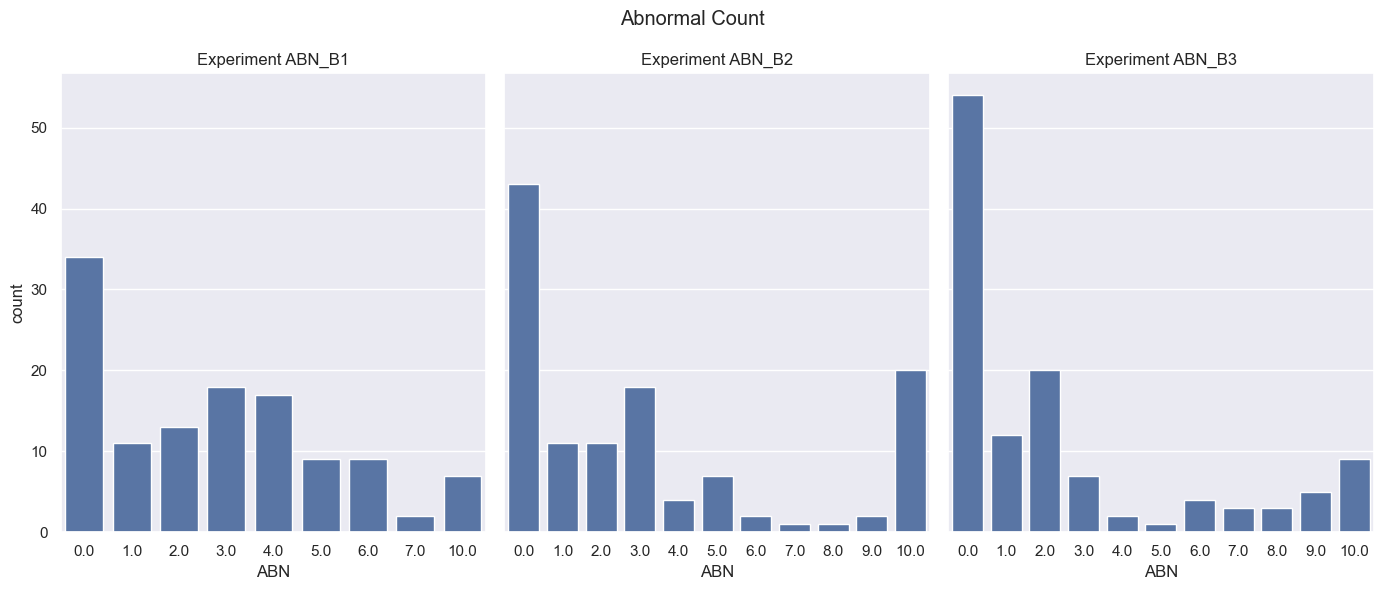

In [55]:
# Checking abnormalities throughout experiments
# Plotting countplot
fig, axes = plt.subplots(figsize=(14,6), nrows=1, ncols=3, sharey='row')
for idx, ax in enumerate(axes.flatten()):
    # Experiment batch
    experiment = f"ABN_B{idx+1}"
    # Load csv data
    df = pd.read_csv(eval(experiment))

    # Plotting countplot
    sns.countplot(df, x='ABN', ax=ax)
    ax.set_title(f"Experiment {experiment}")

fig.suptitle(f"Abnormal Count")
plt.tight_layout()
plt.show()

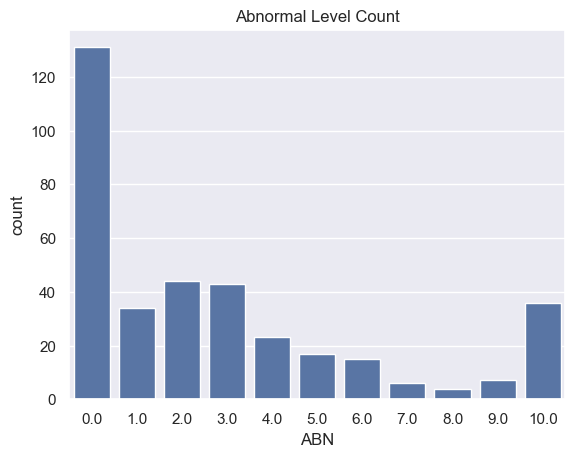

In [56]:
df_all = pd.DataFrame()

for idx in range(3):
    # Experiment batch
    experiment = f"ABN_B{idx+1}"

    df = pd.read_csv(eval(experiment)).dropna()
    df['experiment'] = experiment

    # Load csv data
    df_all = pd.concat([df_all, df]).reset_index(drop=True)

# Plotting countplot
sns.countplot(df_all, x='ABN')
plt.title(f"Abnormal Level Count")
plt.show()

## Relationship between Hovering and Abnormal Level

- Hovering BTM and Abnormal Level (down trend)
- Hovering SUR and Abnormal Level (up trend)

In [57]:
def relation_bars(feature, label='ABN', positions=['BTM', 'MID', 'SUR']):
    for position in positions:
        # Plotting barplot
        fig, axes = plt.subplots(figsize=(14,6), nrows=1, ncols=3, sharey='row')
        for idx, ax in enumerate(axes.flatten()):
            # Experiment batch
            experiment = f"ABN_B{idx+1}"
            # Load csv data
            df = pd.read_csv(eval(experiment))

            sns.barplot(df, x=label, y=f"{feature} {position}", ax=ax)
            ax.set_title(f"Experiment {experiment}")

        fig.suptitle(f"Relationship Between {feature} {position} and {label}")
        plt.tight_layout()
        plt.show

    fig, axes = plt.subplots(figsize=(14,6), nrows=len(positions), ncols=1)
    for idx, ax in enumerate(axes.flatten()):
        sns.barplot(df_all, x='ABN', y=f"{feature} {positions[idx]}", ax=ax)

    fig.suptitle(f"Relationship Between {feature} Position and {label} For All Experiment")
    plt.tight_layout()
    plt.show()

def relation_lines(feature, label='DO', positions=['BTM', 'MID', 'SUR']):
    for position in positions:
        # Plotting lineplot
        fig, axes = plt.subplots(figsize=(12,6), nrows=3, ncols=1, sharey='col')
        for idx, ax in enumerate(axes.flatten()):
            # Experiment batch
            experiment = f"ABN_B{idx+1}"
            # Load csv data
            df = pd.read_csv(eval(experiment))

            sns.lineplot(df, x=label, y=f"{feature} {position}", ax=ax)
            ax.set_title(f"Experiment {experiment}")

        fig.suptitle(f"Relationship Between {feature} {position} and {label}")
        plt.tight_layout()
        plt.show()

def relation_bar(feature, label='ABN'):
    # Every batch experiment
    fig, axes = plt.subplots(figsize=(14,6), nrows=1, ncols=3, sharey='row')
    for idx, ax in enumerate(axes.flatten()):
        # Experiment batch
        experiment = f"ABN_B{idx+1}"
        # Load csv data
        df = pd.read_csv(eval(experiment))

        sns.barplot(df, x=label, y=feature, ax=ax)
        ax.set_title(f"Experiment {experiment}")

    fig.suptitle(f"Relationship Between {feature} and {label}")
    plt.tight_layout()
    plt.show()

    # All experiment
    plt.figure(figsize=(14, 6))
    sns.barplot(df_all, x=label, y=feature)
    plt.title(f"Relationship Between {feature} and {label} For All Experiment")
    plt.show()

def relation_line(feature, label='DO'):
    fig, axes = plt.subplots(figsize=(12,6), nrows=3, ncols=1)
    for idx, ax in enumerate(axes.flatten()):
        # Experiment batch
        experiment = f"ABN_B{idx+1}"
        # Load csv data
        df = pd.read_csv(eval(experiment))

        sns.lineplot(df, x='DO', y=feature, ax=ax)
        ax.set_title(f"Experiment {experiment}")

    fig.suptitle(f"Relationship Between {feature} and {label}")
    plt.tight_layout()
    plt.show()

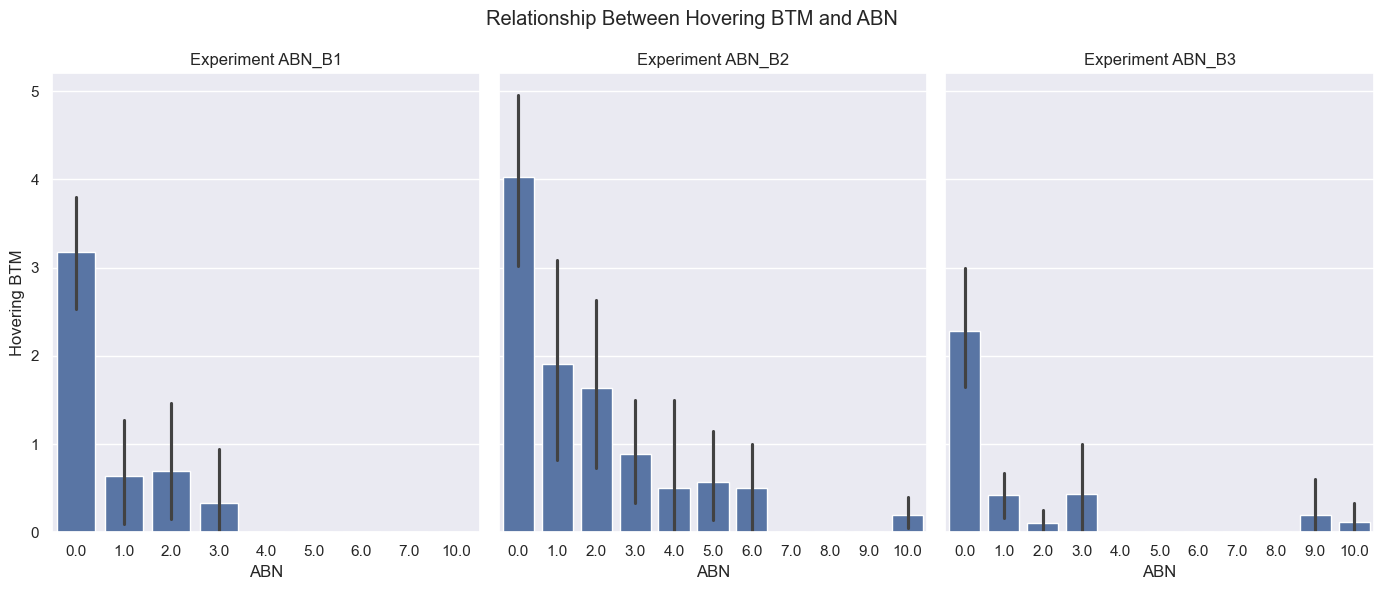

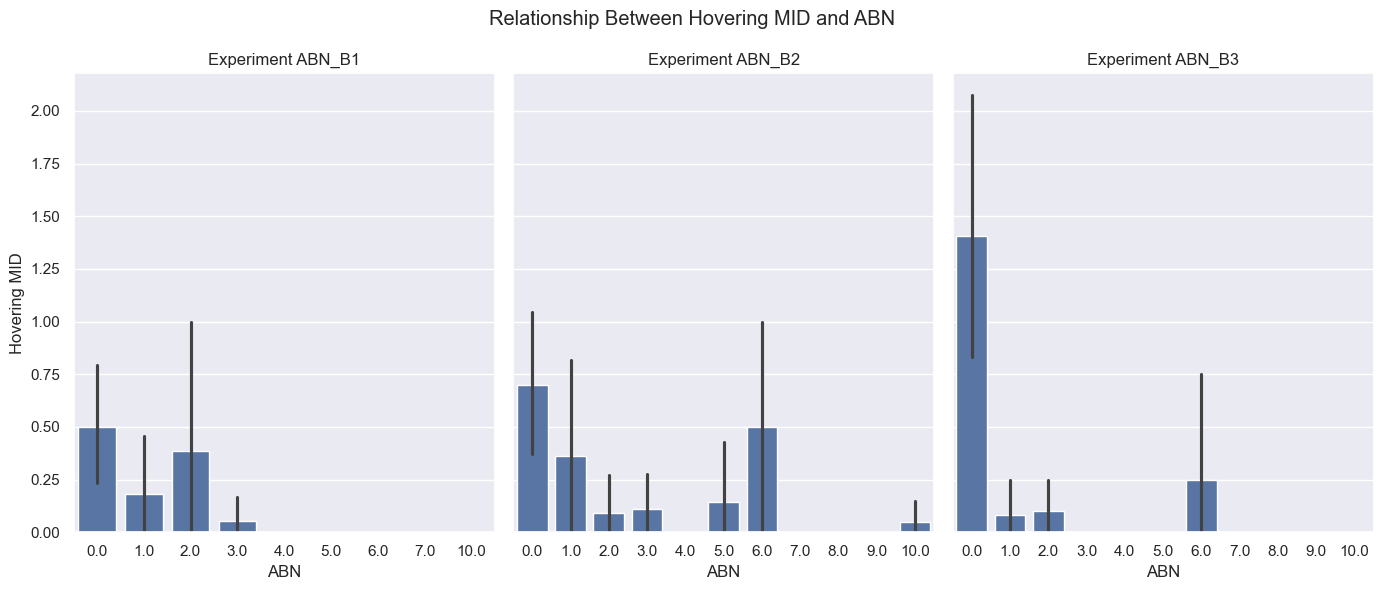

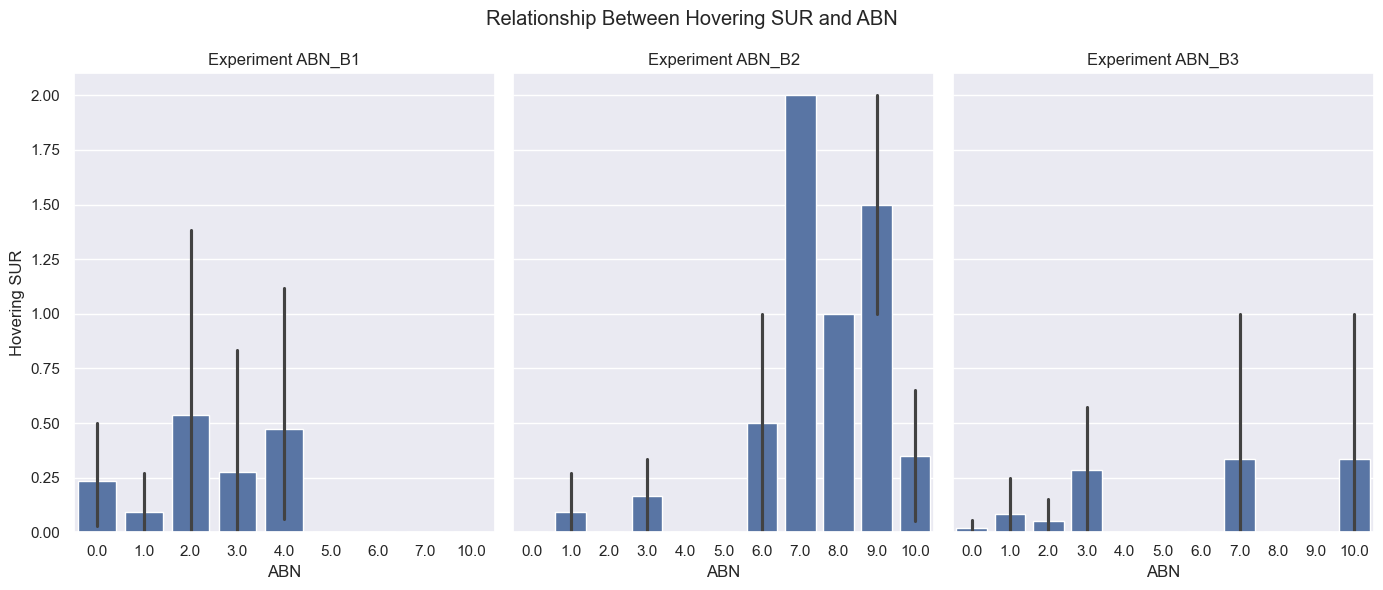

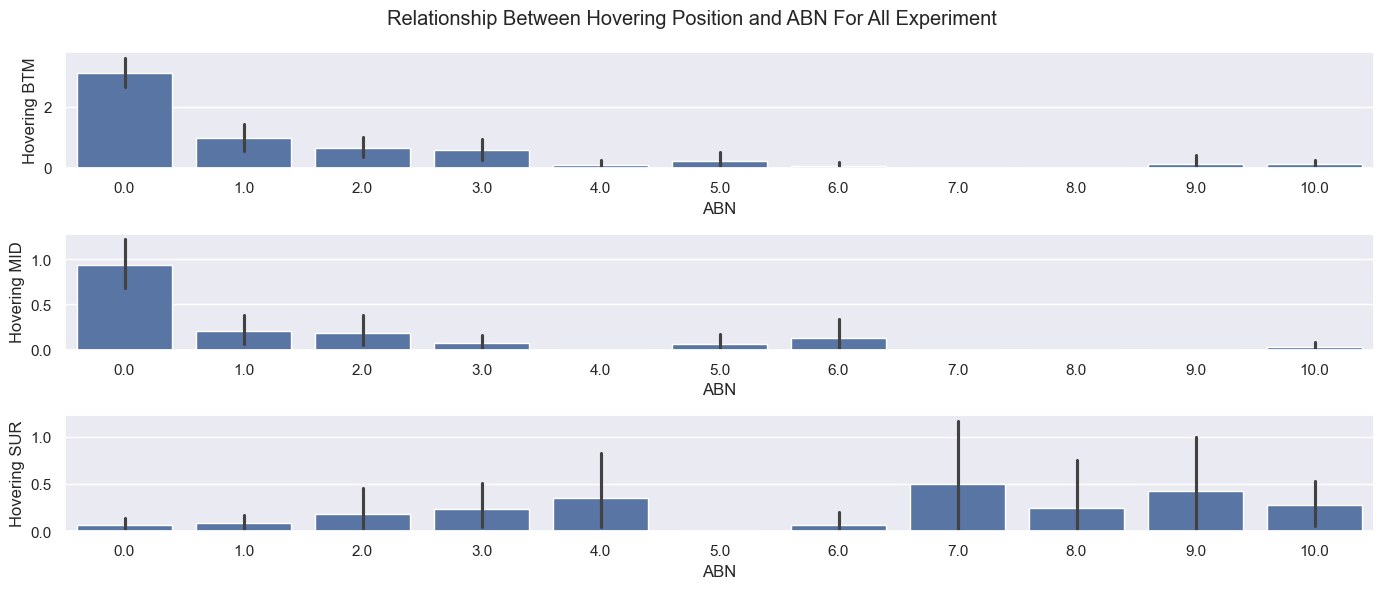

In [58]:
relation_bars(feature='Hovering')

## Relationship between Hovering and DO

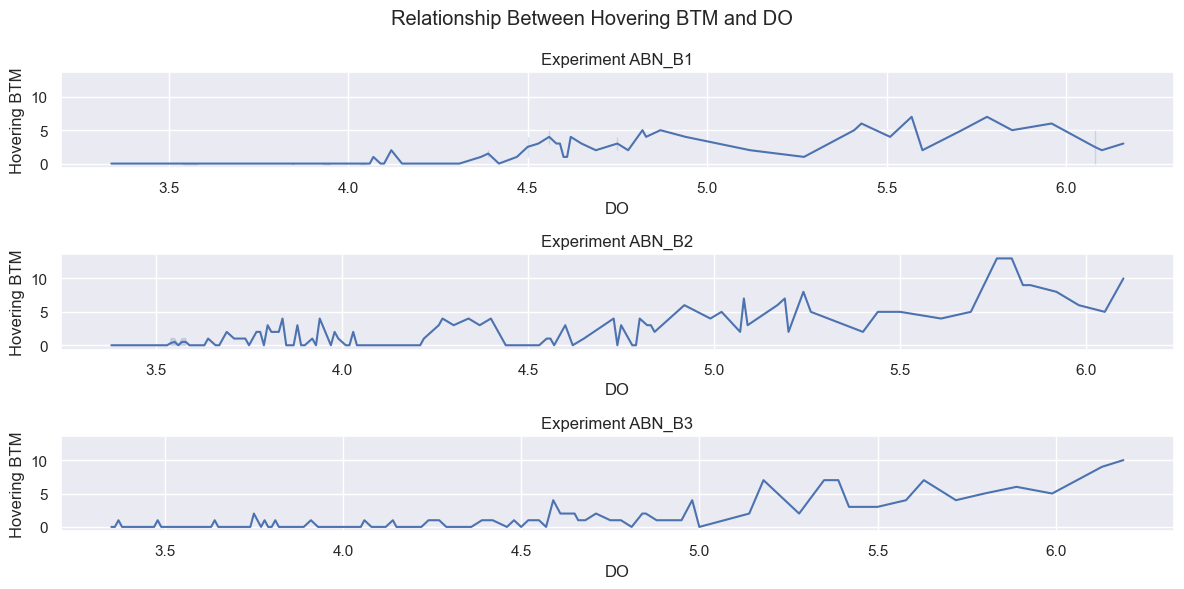

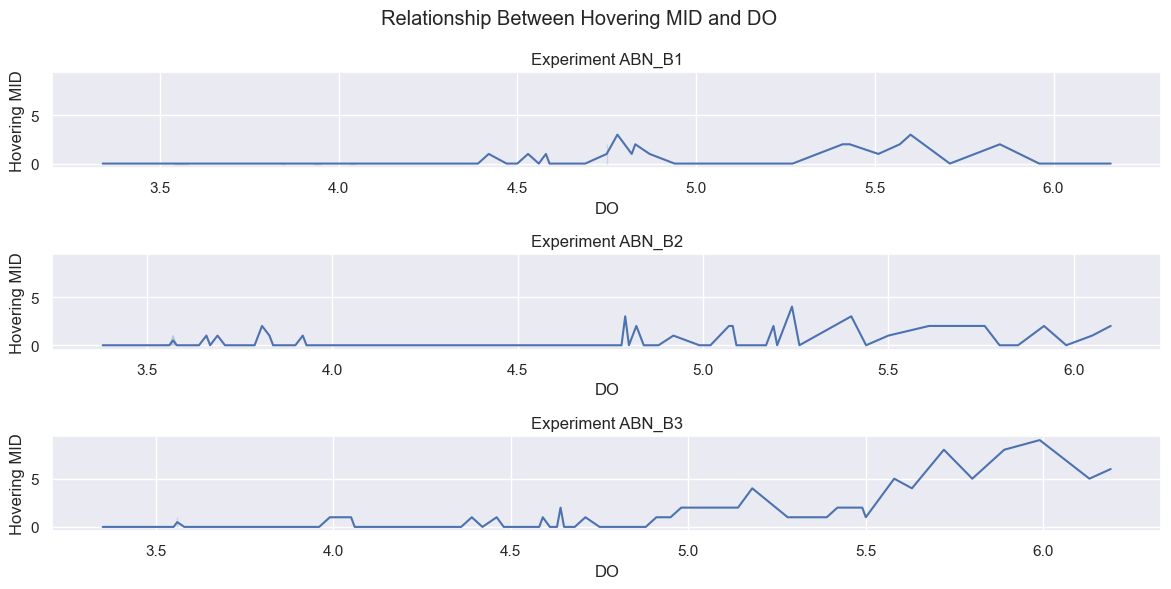

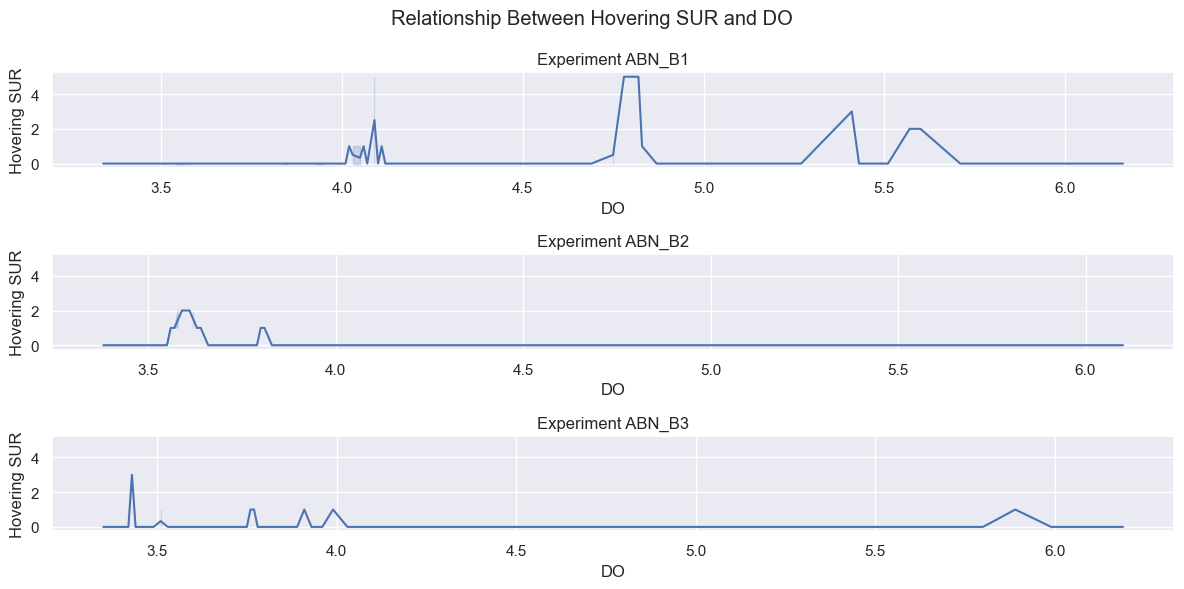

In [59]:
relation_lines(feature='Hovering')

## Relationship between Fast Swim and Abnormal Level
- Fast Swim MID and Abnormal Level (up trend)
- Fast Swim SUR and Abnormal Level (up trend)

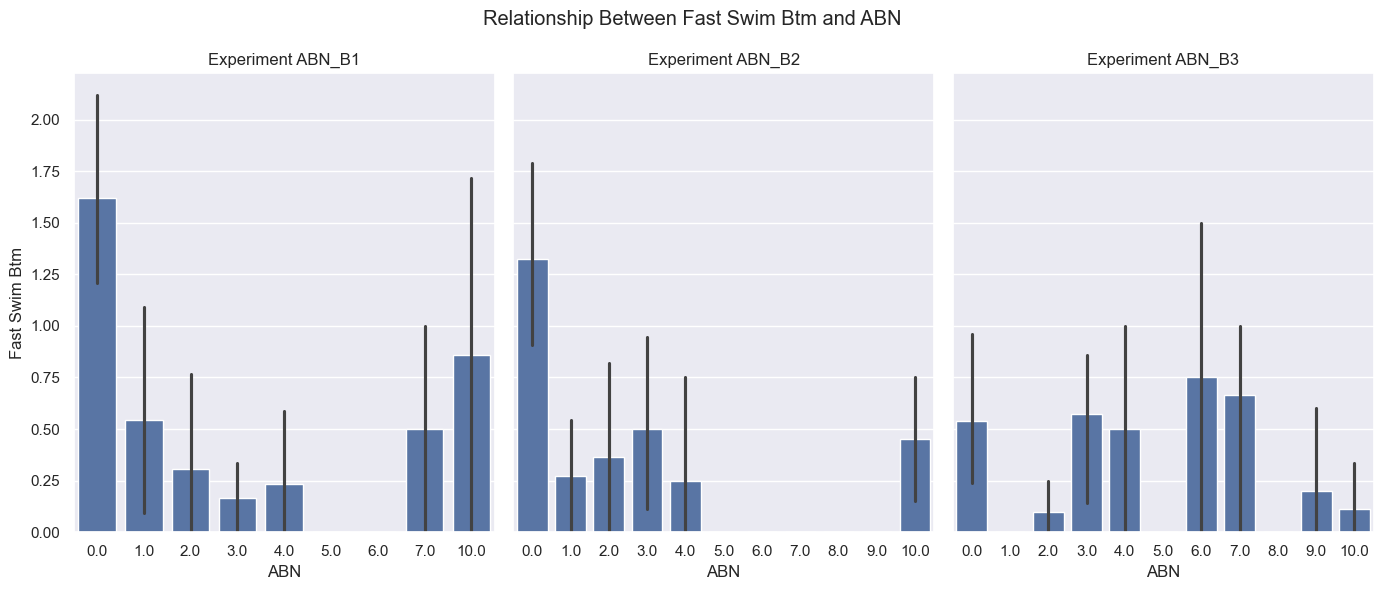

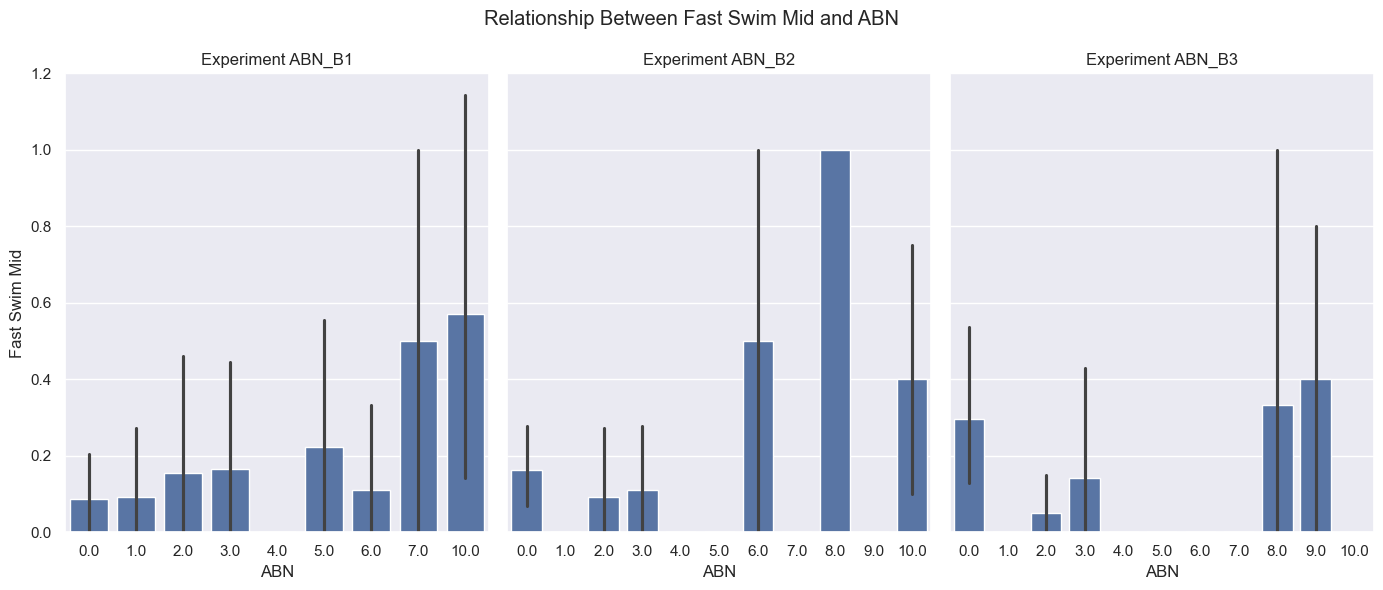

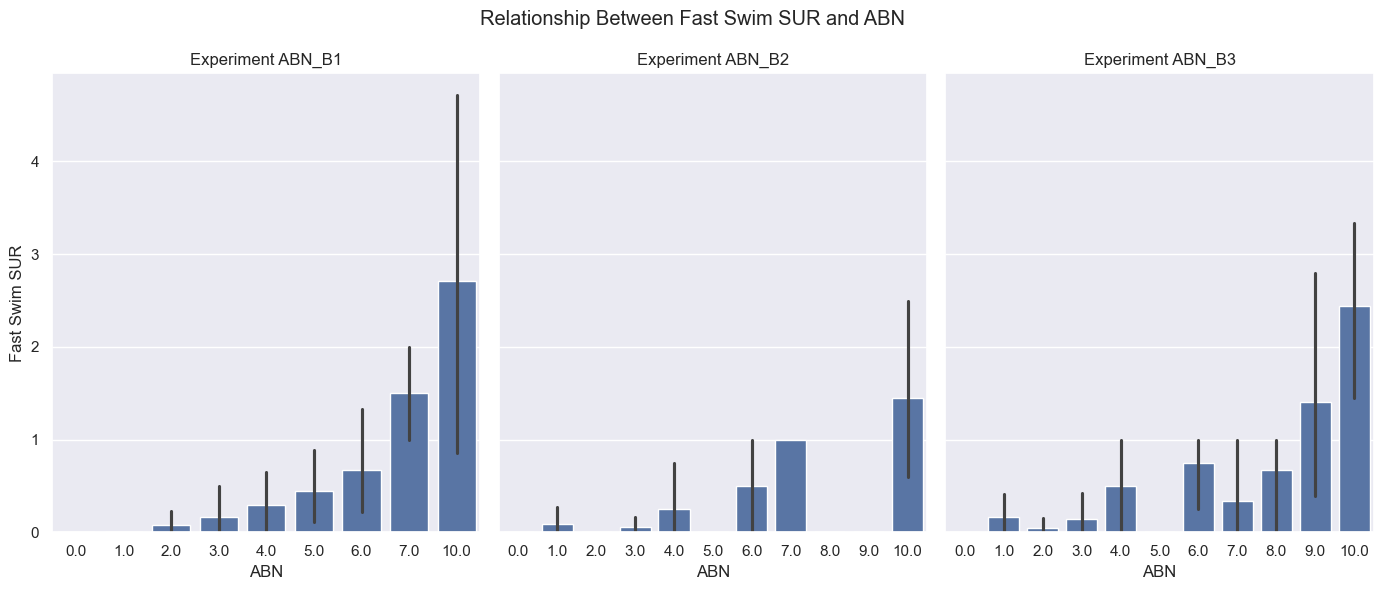

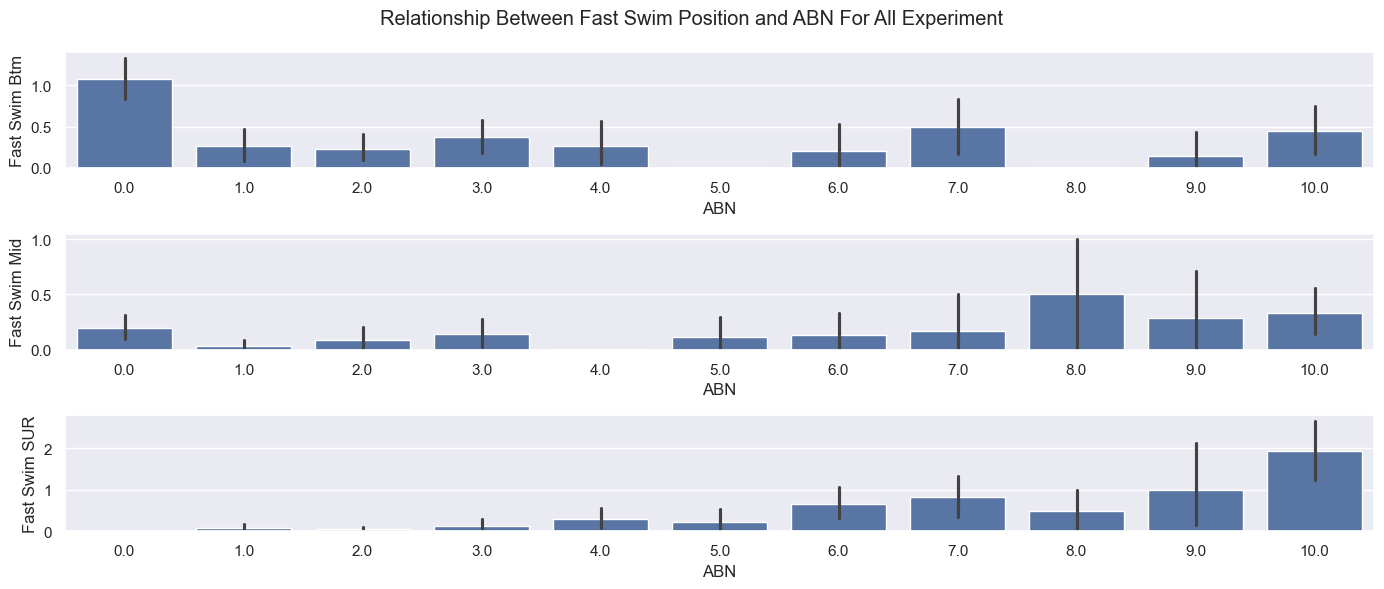

In [60]:
relation_bars(feature='Fast Swim', positions=['Btm', 'Mid', 'SUR'])

## Relationship between Fast Swimming and DO

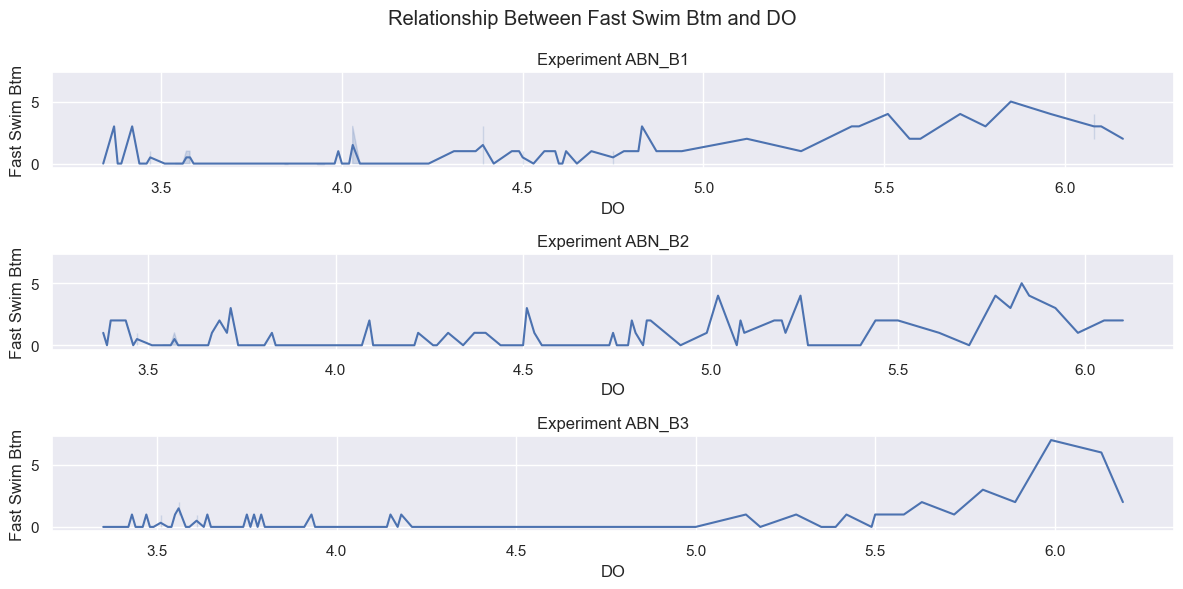

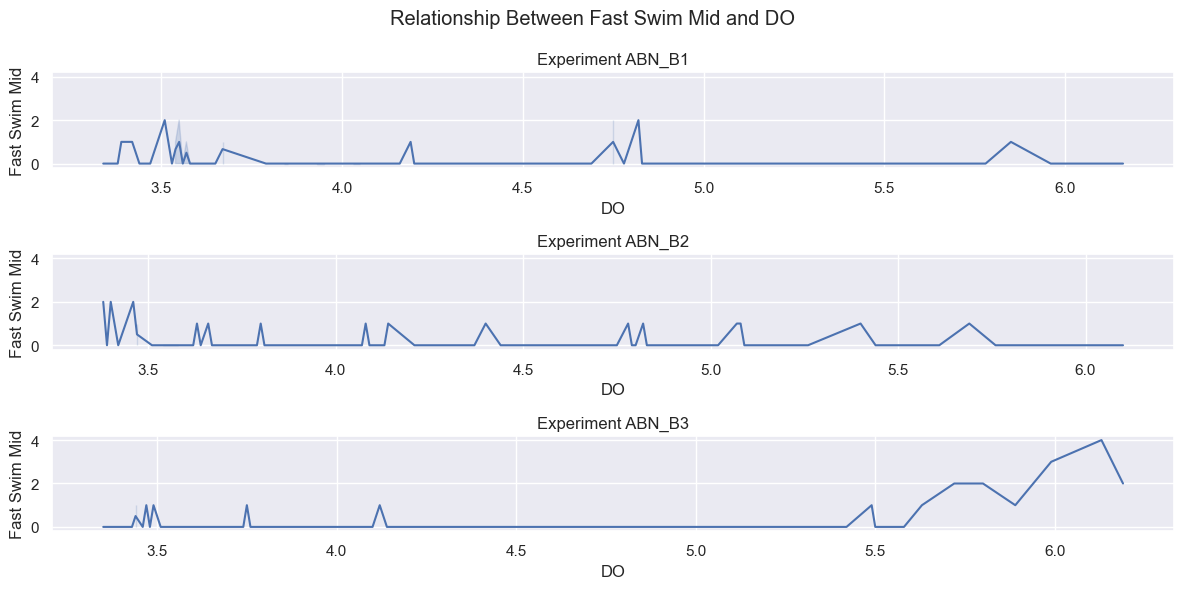

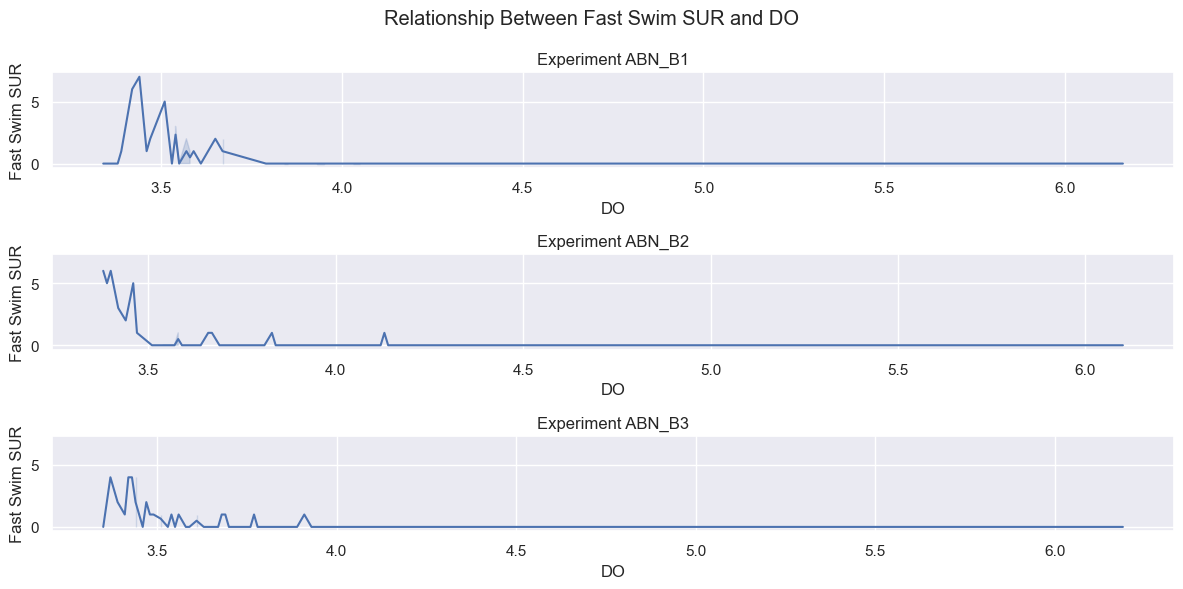

In [61]:
relation_lines(feature='Fast Swim', positions=['Btm', 'Mid', 'SUR'])

## Relationship beween Burst Swimming and Abnormal Level

- Burst Swimming and Abnormal Level (up trend)

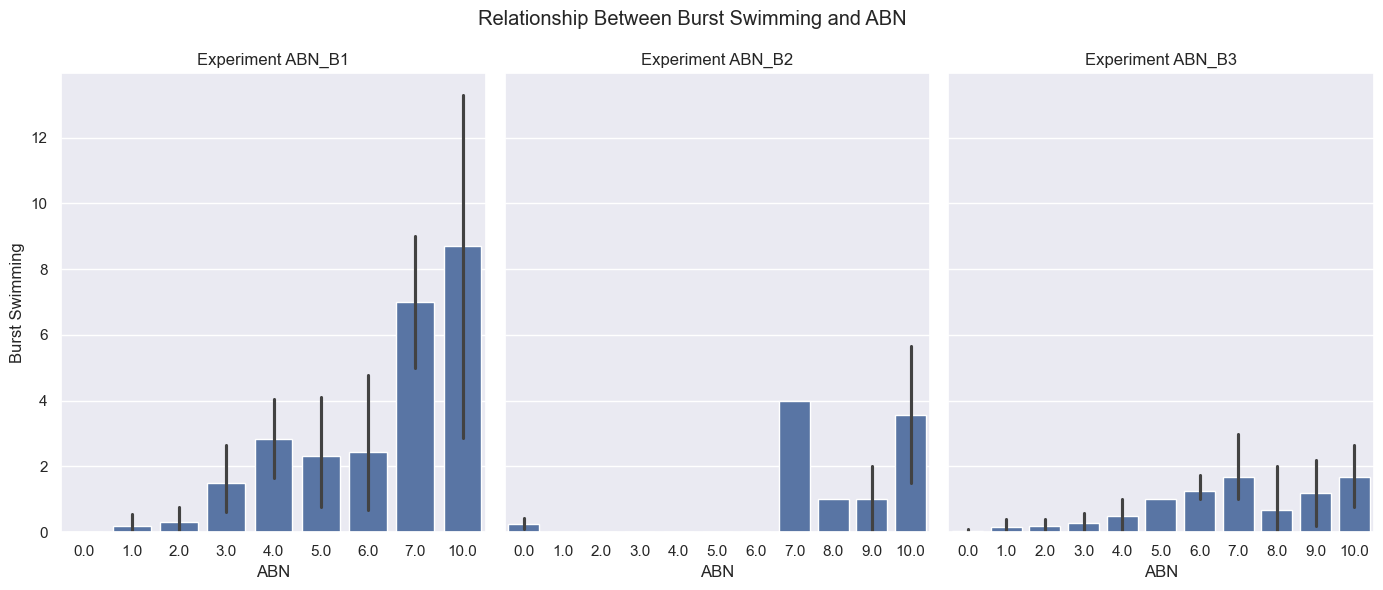

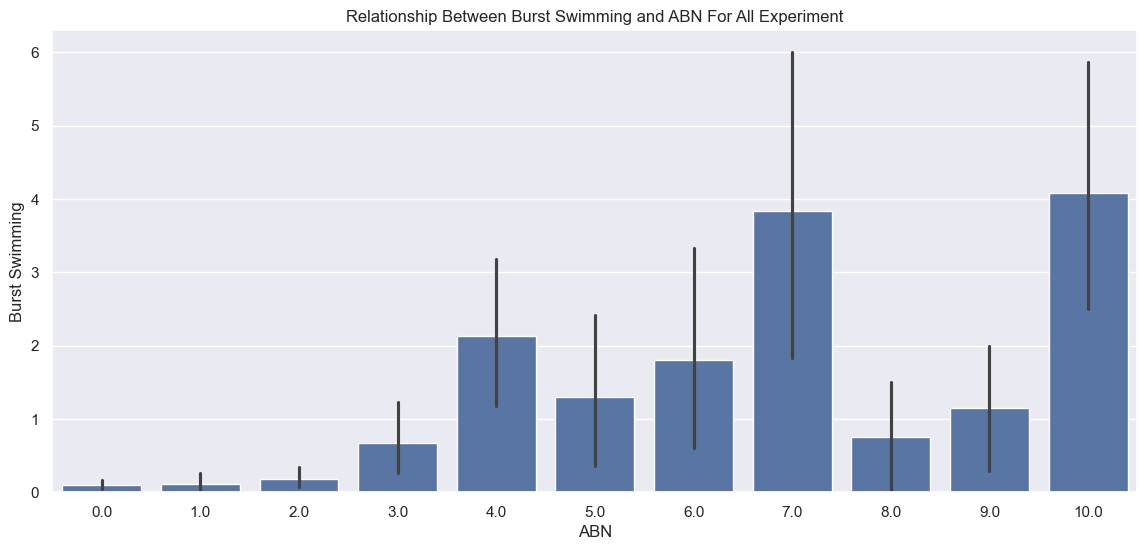

In [62]:
relation_bar(feature='Burst Swimming')

## Relationship between Burst Swimming and DO

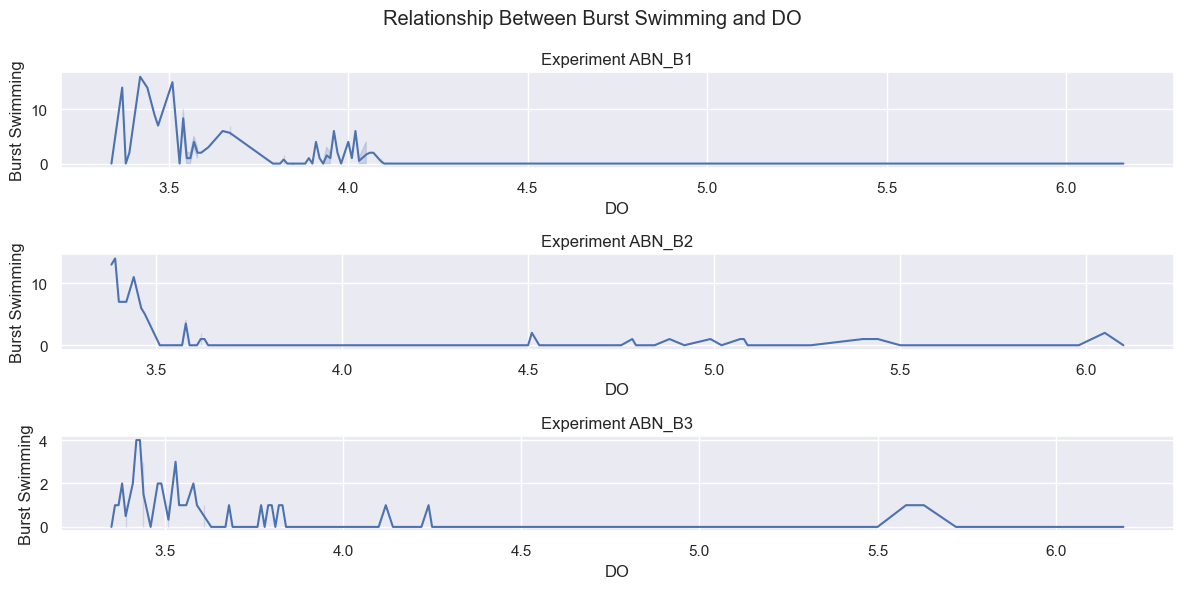

In [63]:
relation_line(feature='Burst Swimming')

## Relationship beween Acc. Ver. Position and Abnormal Level

- Acc. Ver. MID and Abnormal Level (up trend)
- Acc. Ver. SUR and Abnormal Level (up trend)

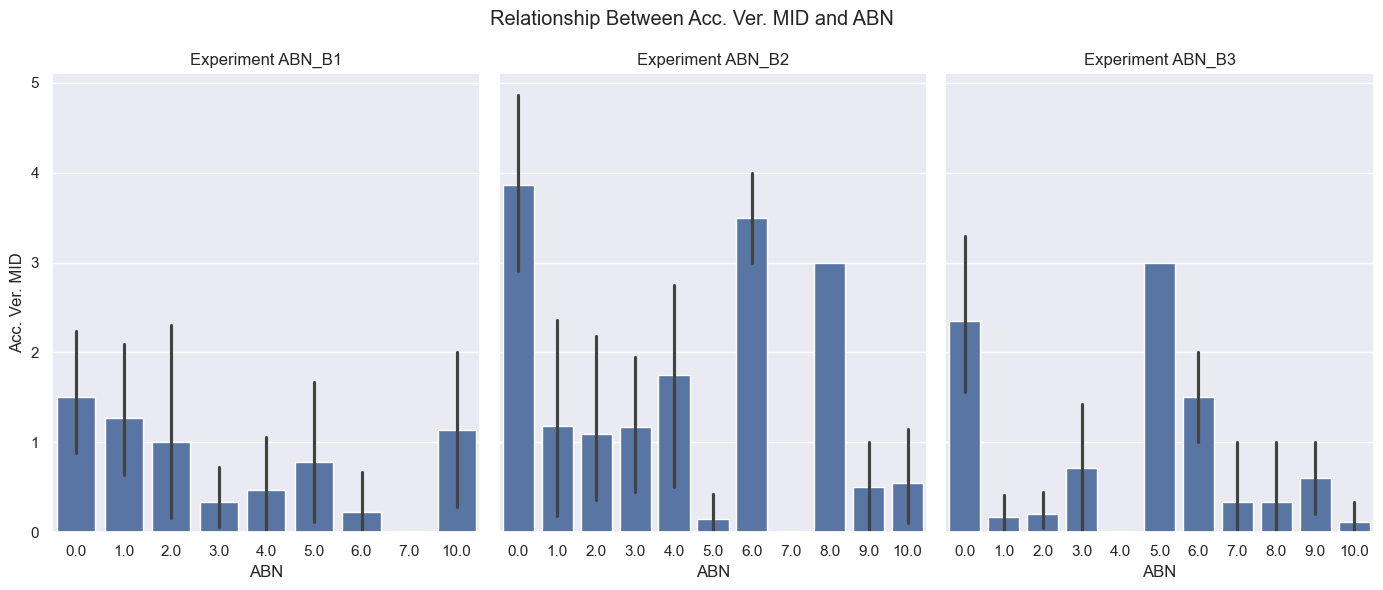

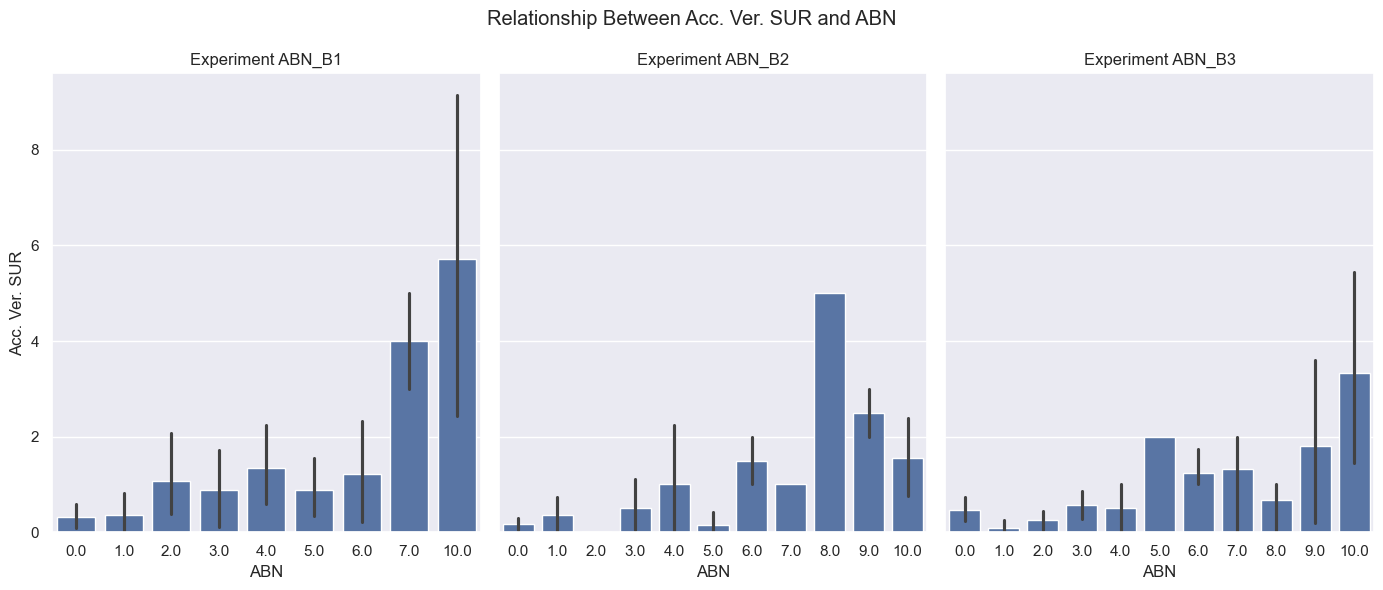

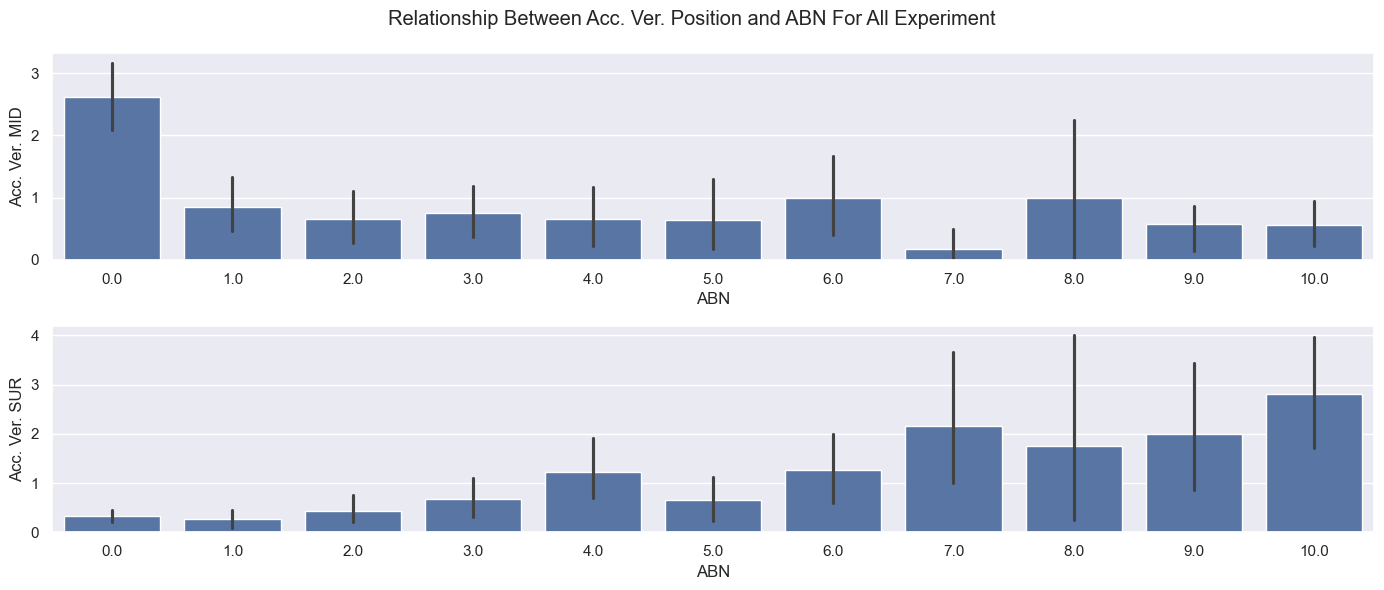

In [64]:
relation_bars(feature='Acc. Ver.', positions=['MID', 'SUR'])

## Relationship between Acc. Ver. Position and DO

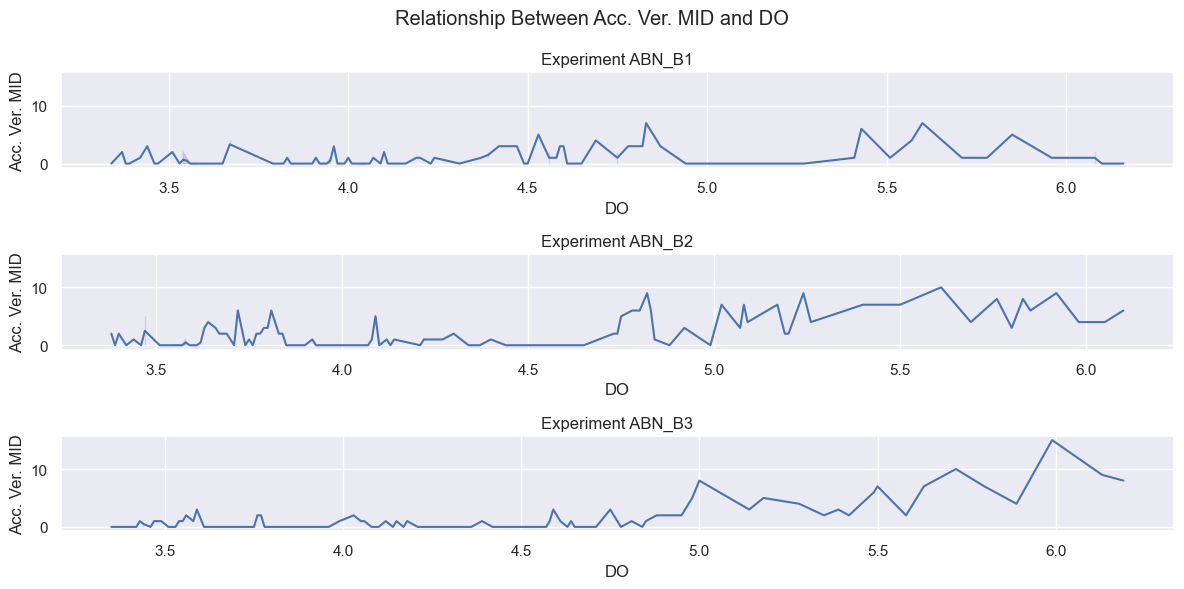

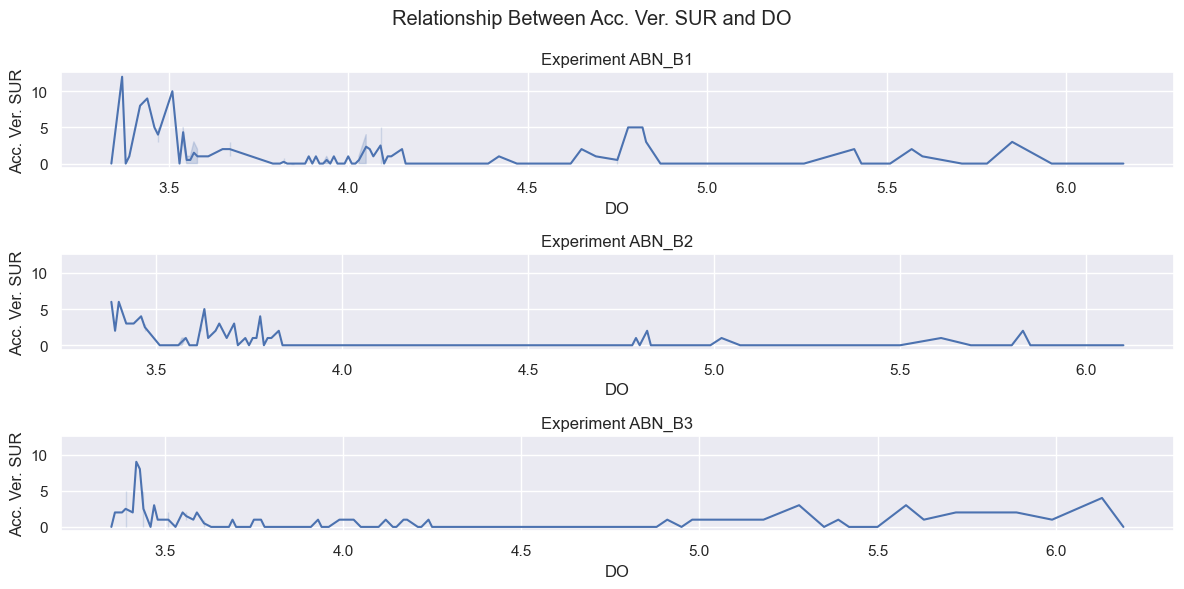

In [65]:
relation_lines(feature='Acc. Ver.', positions=['MID', 'SUR'])

## Relationship between Turning and Abnormal Level
- Turning and Abnormal Level (down trend)

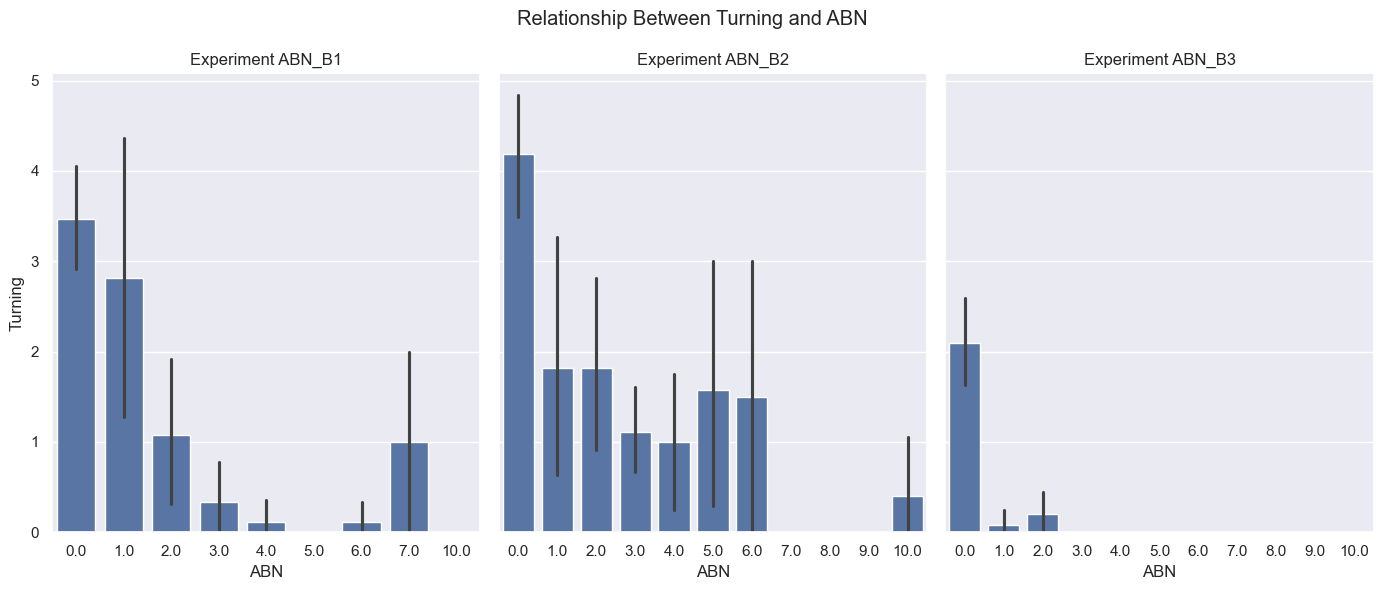

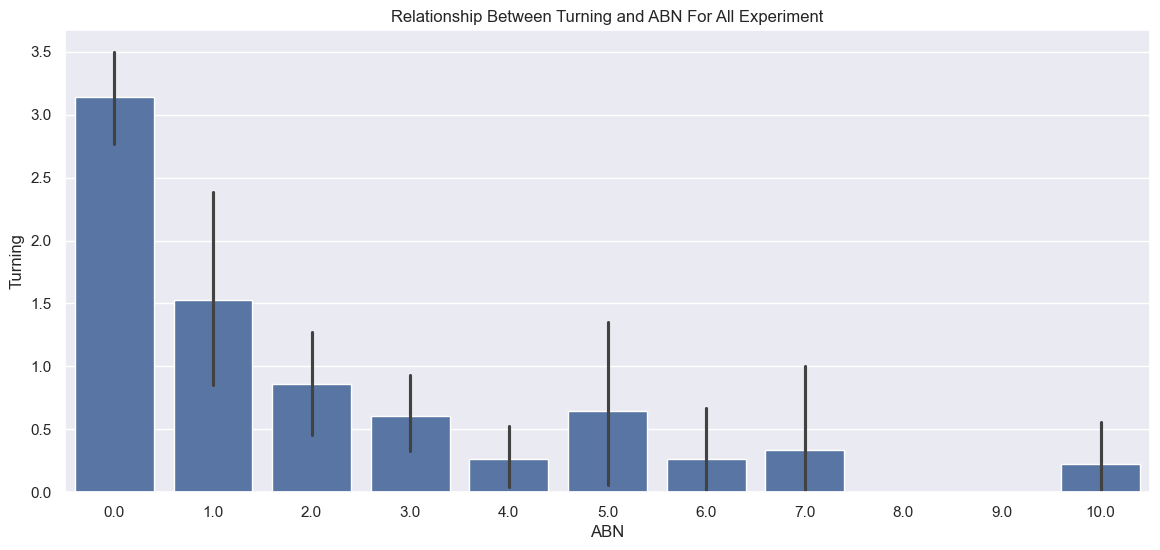

In [66]:
relation_bar(feature='Turning')

## Relationship between Turning and DO

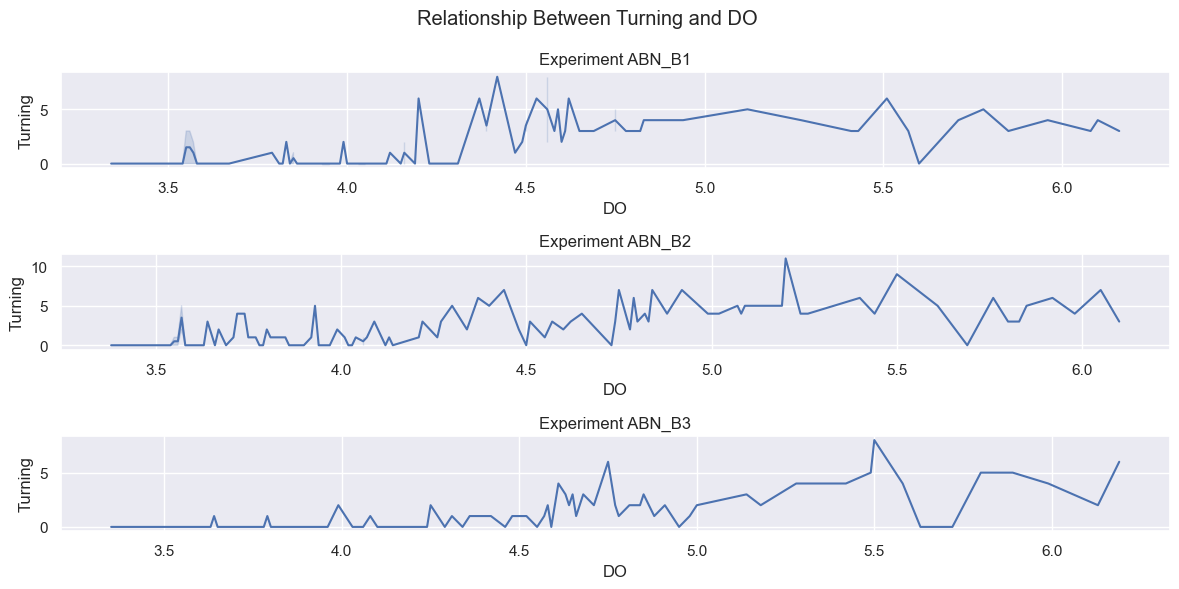

In [67]:
relation_line(feature='Turning')

## Relationship between Agg. Behavior and Abnormal Level

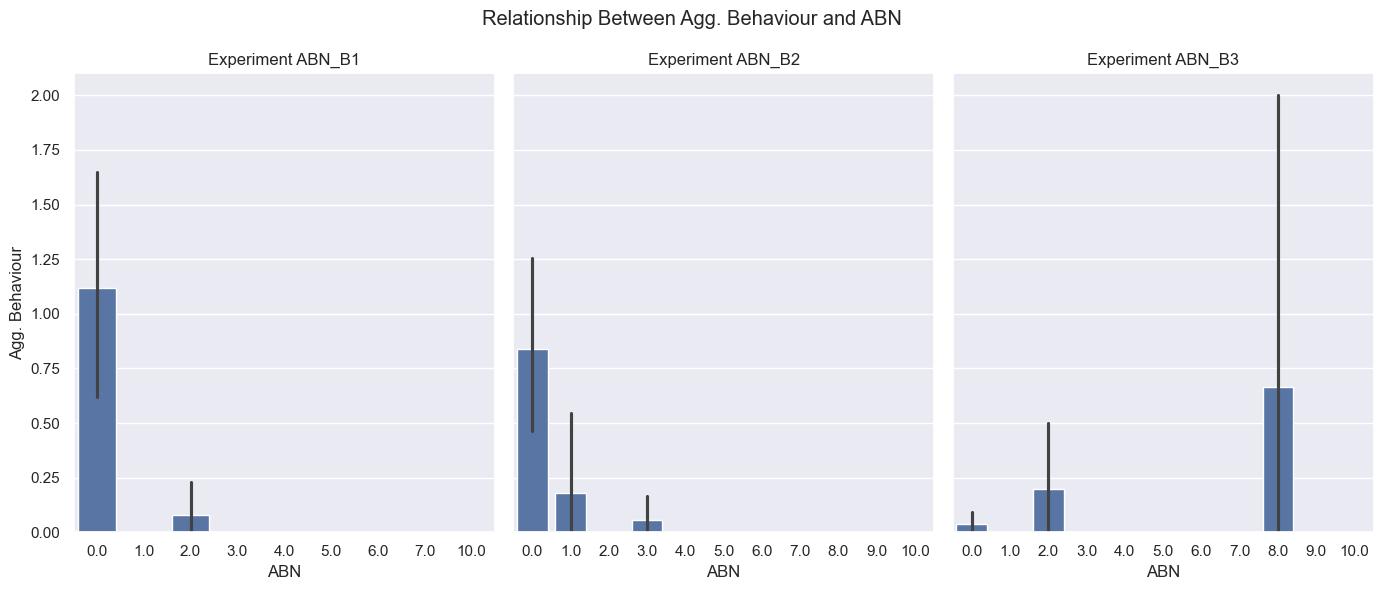

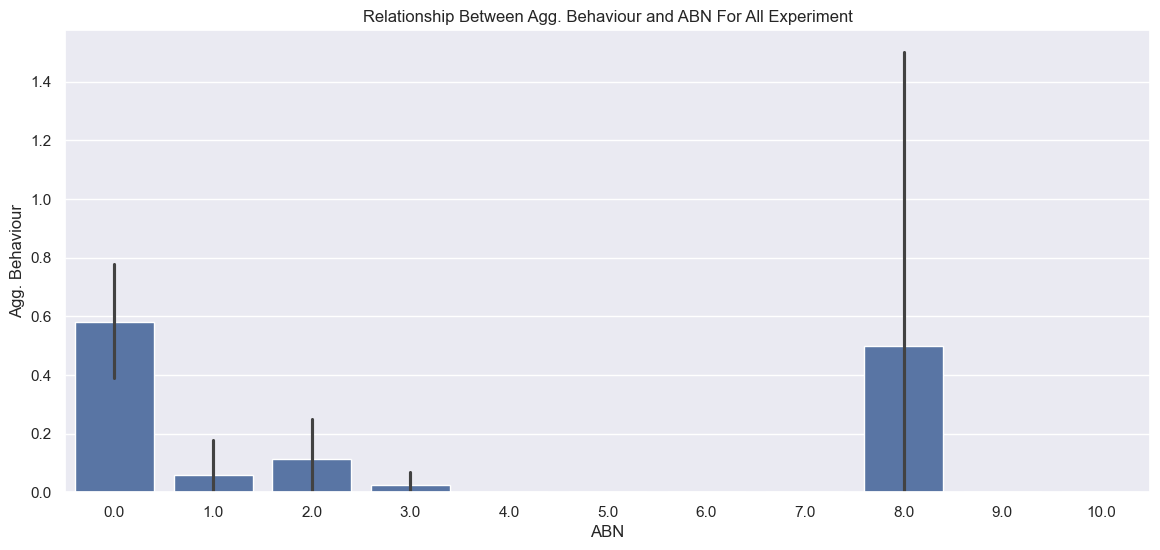

In [68]:
relation_bar(feature='Agg. Behaviour')

## Relationship betweeen Agg. Behaviour and DO

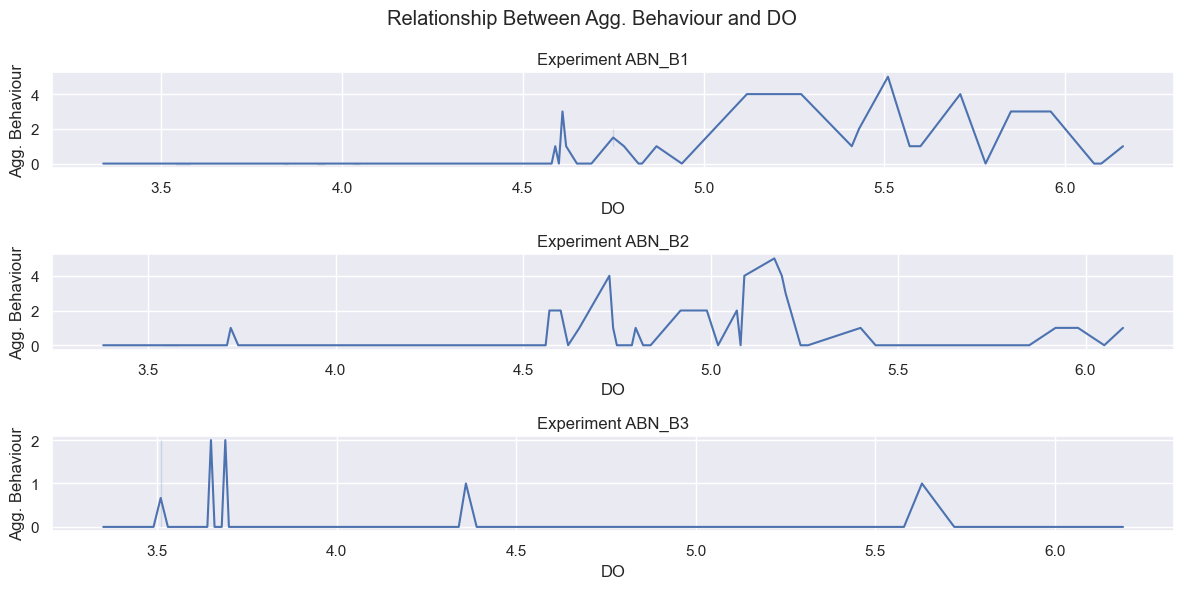

In [69]:
relation_line(feature='Agg. Behaviour')

## Relationship between Resting and Abnormal Level

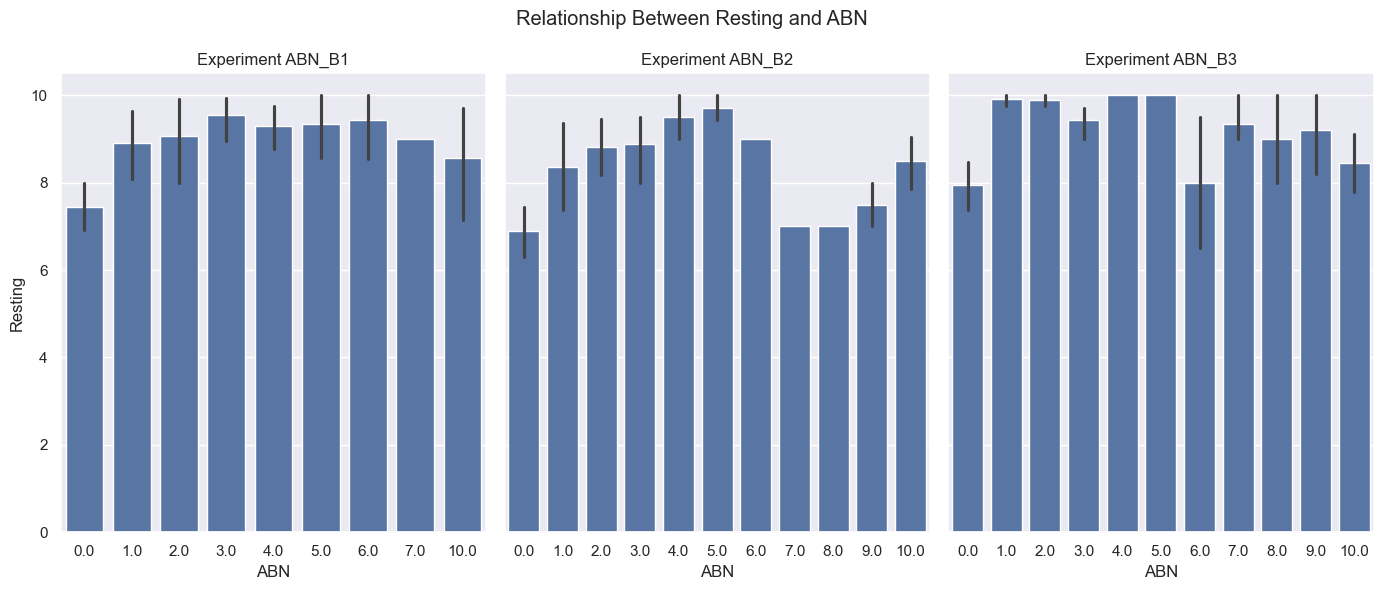

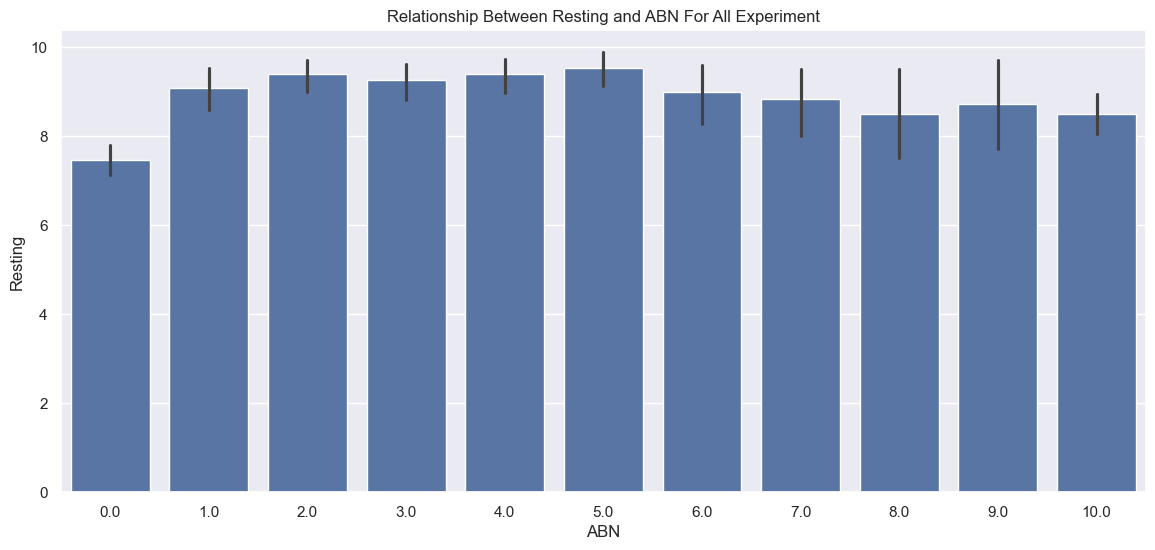

In [70]:
relation_bar(feature='Resting')

## Relationship between Resting and DO

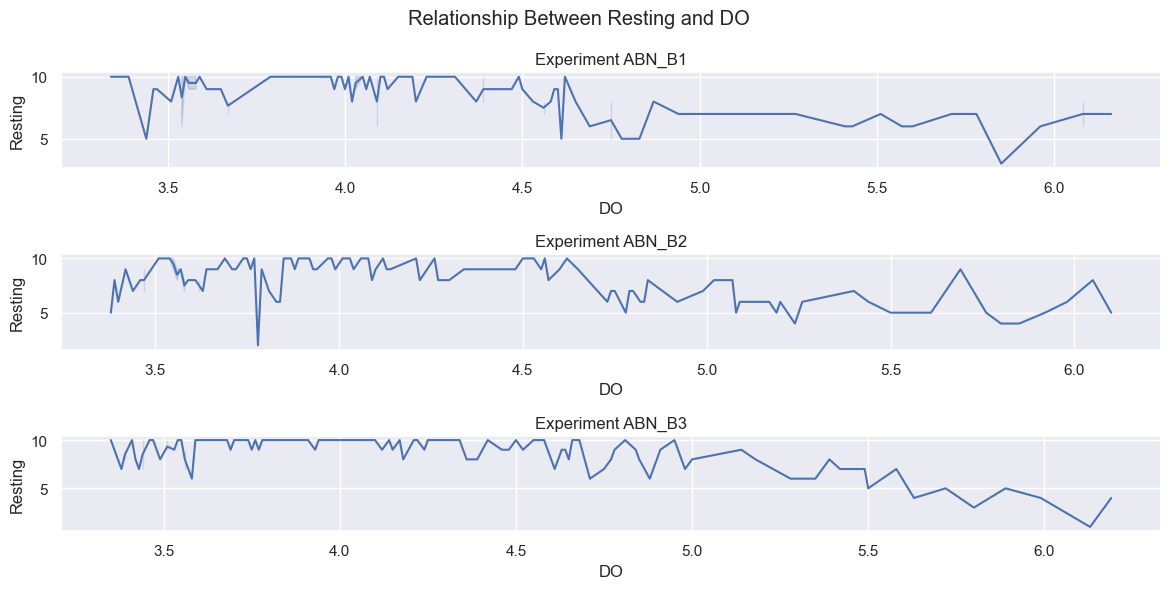

In [71]:
relation_line(feature='Resting')

## Relationship between Active and Abnormal Level

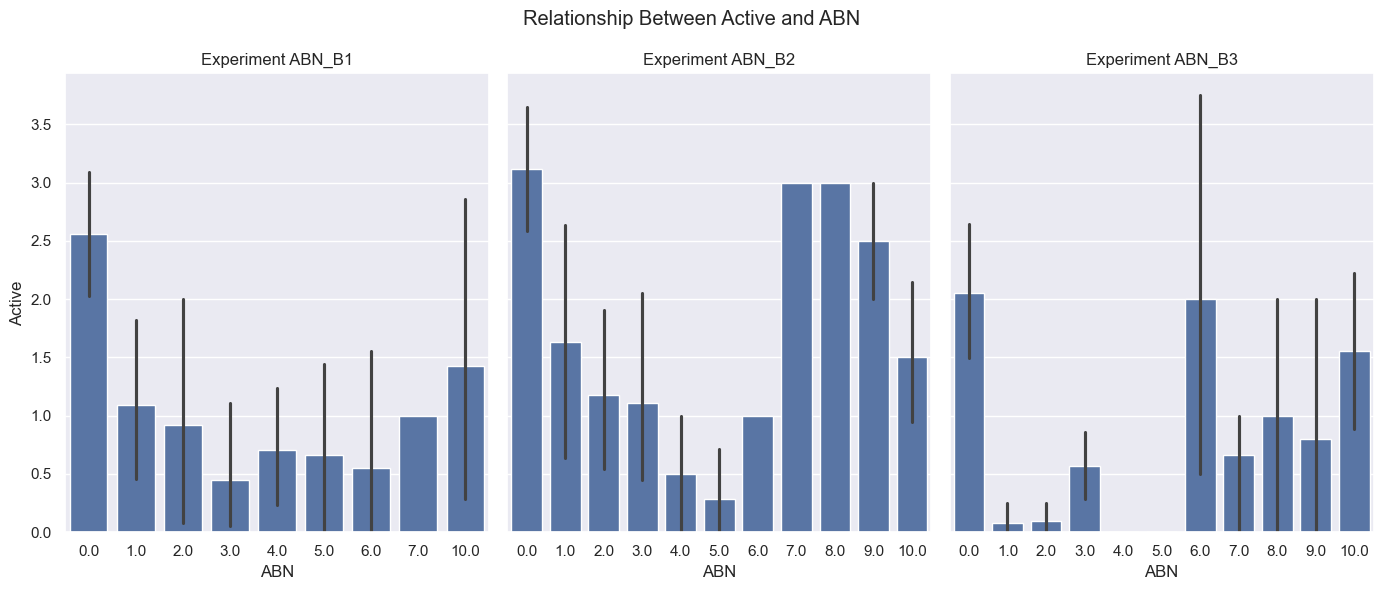

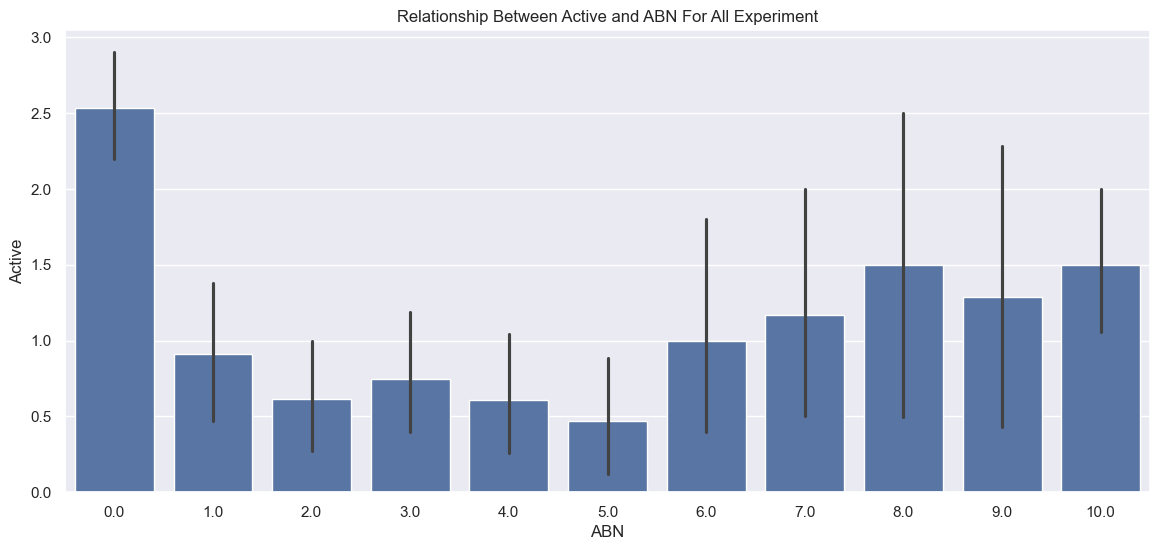

In [72]:
relation_bar(feature='Active')

## Relationship between Active and DO

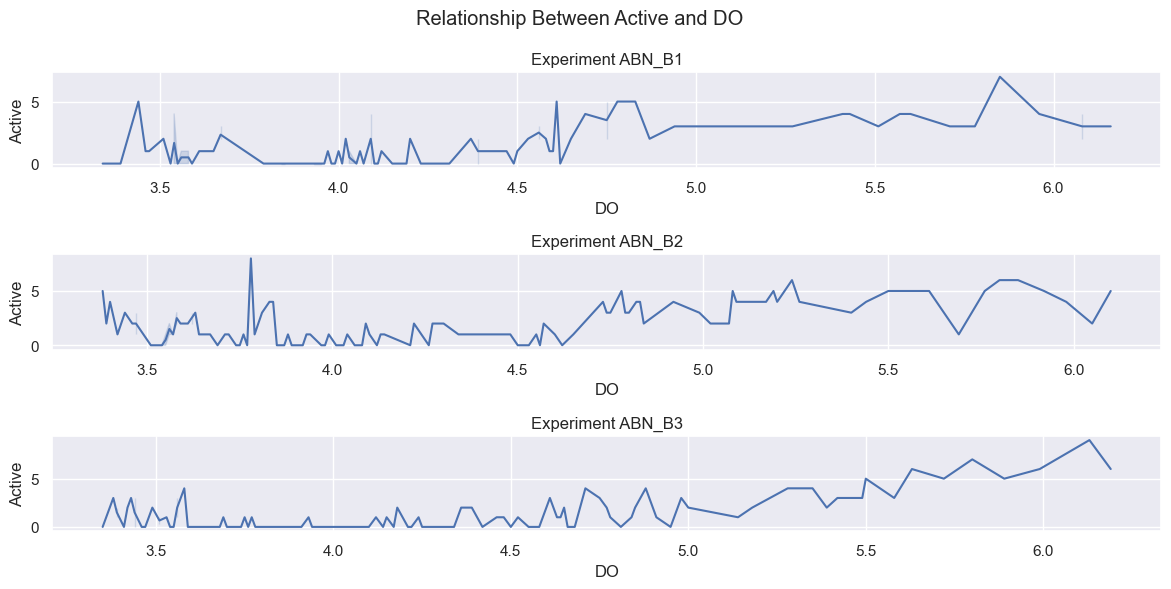

In [73]:
relation_line(feature='Active')

### Checking Distribution

In [74]:
conti = [
    'Hovering BTM', 
    'Hovering MID',
    'Hovering SUR', 
    'Fast Swim Btm', 
    'Fast Swim Mid', 
    'Fast Swim SUR',
    'Acc. Ver. MID', 
    'Acc. Ver. SUR', 
    'Turning', 
    'Agg. Behaviour',
    'Burst Swimming', 
    'Resting', 
    'Active', 
    'BTM', 
    'MID', 
    'SUR']

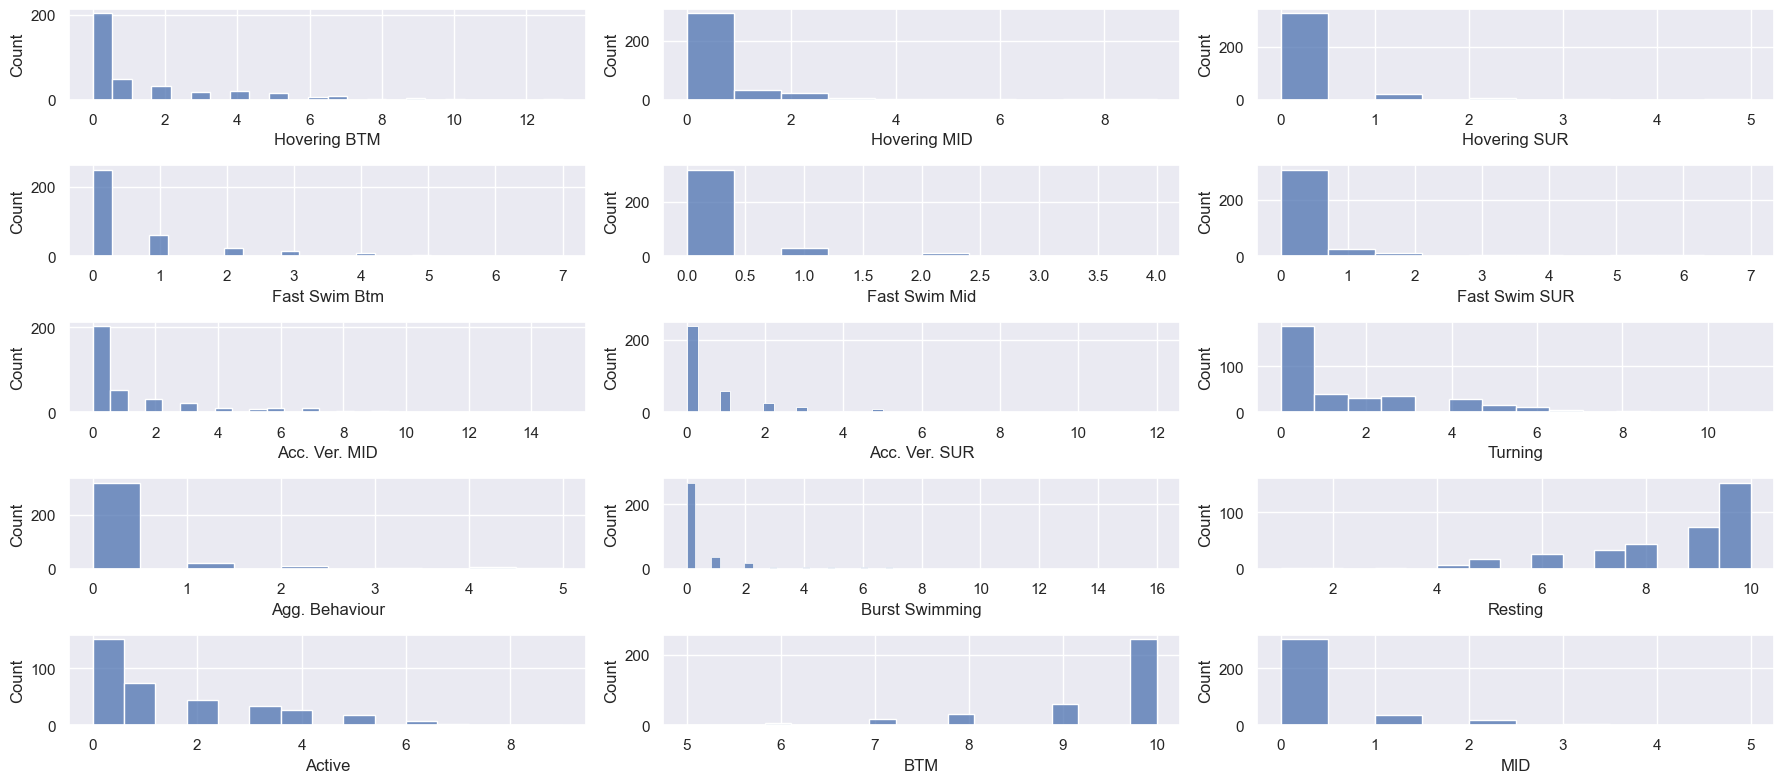

In [75]:
col = 3
row = len(conti) // col

fig, axes = plt.subplots(figsize=(18,8), nrows=row, ncols=col)
for idx, ax in enumerate(axes.flatten()):
    sns.histplot(df_all[conti[idx]], ax=ax)

plt.tight_layout()
plt.show()

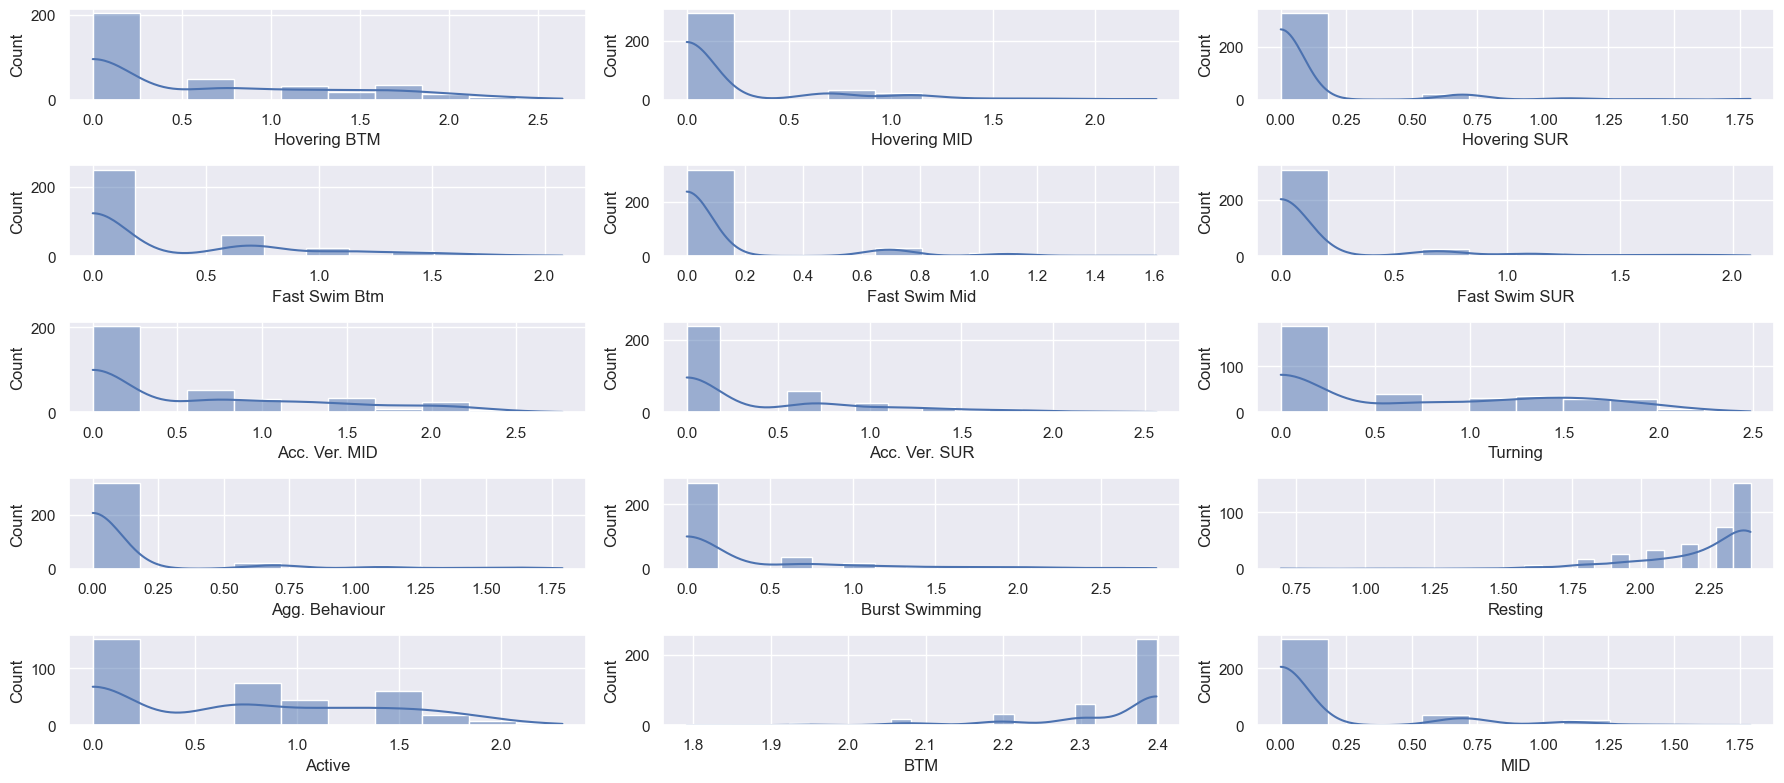

In [76]:
col = 3
row = len(conti) // col

fig, axes = plt.subplots(figsize=(18,8), nrows=row, ncols=col)
for idx, ax in enumerate(axes.flatten()):
    new_col = df_all[conti[idx]].apply(lambda x: np.log1p(x))
    sns.histplot(new_col, kde=True, ax=ax)

plt.tight_layout()
plt.show()

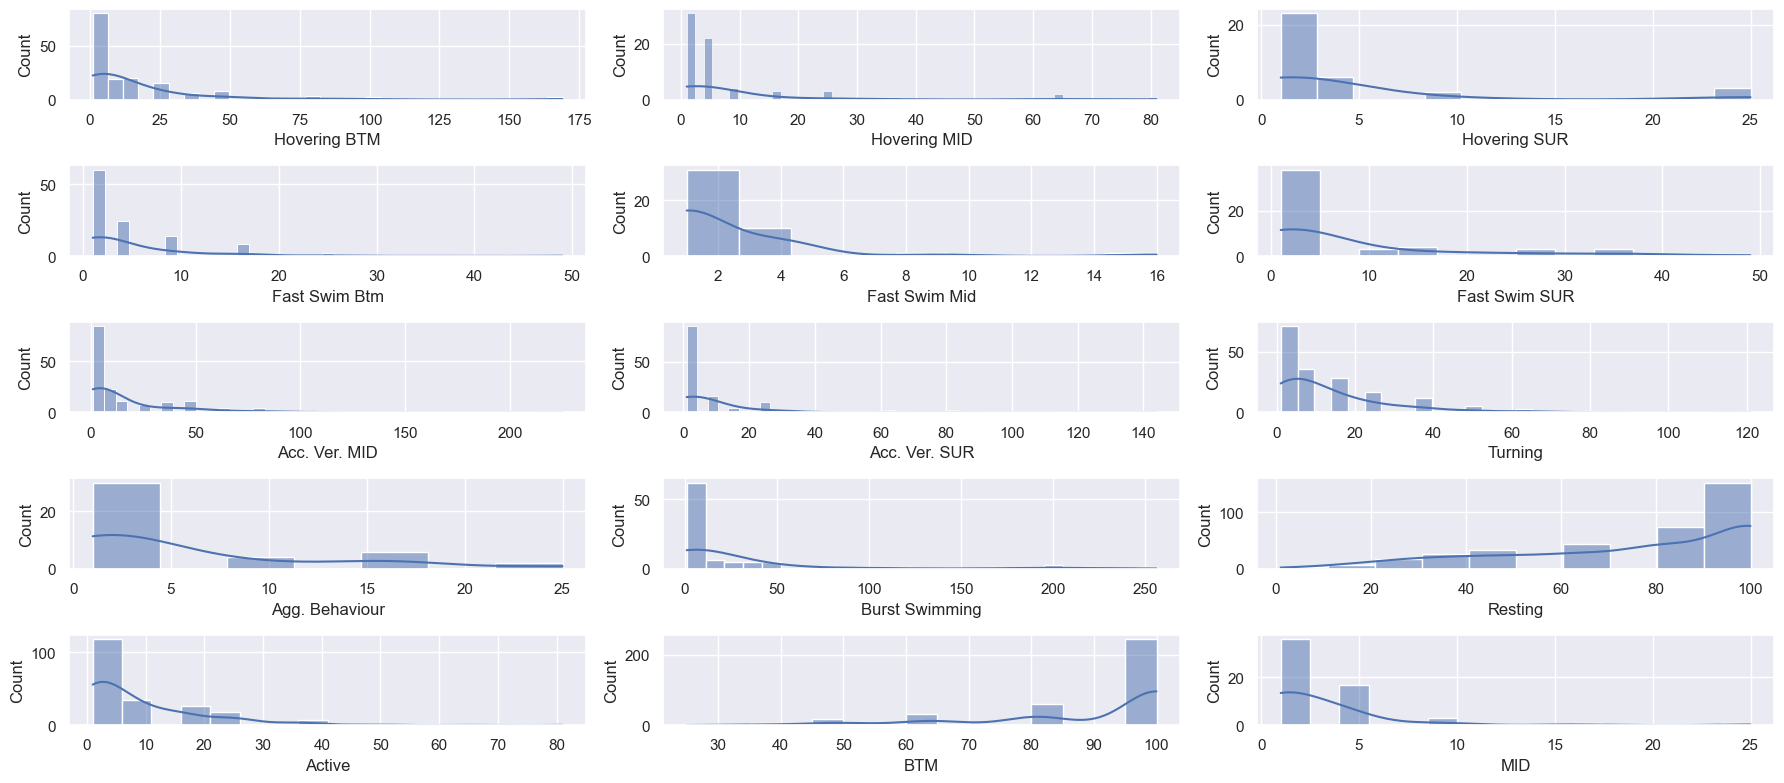

In [77]:
col = 3
row = len(conti) // col

fig, axes = plt.subplots(figsize=(18,8), nrows=row, ncols=col)
for idx, ax in enumerate(axes.flatten()):
    new_col = df_all[conti[idx]].apply(lambda x: np.square(x) if x != 0 else np.nan)
    sns.histplot(new_col, kde=True, ax=ax)

plt.tight_layout()
plt.show()

In [78]:
# Reset theme
sns.reset_orig()

# Feature Selection On All Batch Experiment

In [79]:
df = df_all.copy()
df = df.dropna()
df.head()

,time_start,time_ end,DO,Hovering BTM,Hovering MID,Hovering SUR,Fast Swim Btm,Fast Swim Mid,Fast Swim SUR,Acc. Ver. MID,...,Burst Swimming,Resting,Active,BTM,MID,SUR,N,ABN,ABN%,experiment
0,00:00:00,00:01:00,6.16,3.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,7.0,3.0,10.0,0.0,0.0,10.0,0.0,0.0,ABN_B1
1,00:01:00,00:02:00,6.10,2.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,7.0,3.0,10.0,0.0,0.0,10.0,0.0,0.0,ABN_B1
2,00:02:00,00:03:00,6.08,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,8.0,2.0,10.0,0.0,0.0,10.0,0.0,0.0,ABN_B1
3,00:03:00,00:04:00,6.08,5.0,0.0,0.0,4.0,0.0,0.0,2.0,...,0.0,6.0,4.0,9.0,1.0,0.0,10.0,0.0,0.0,ABN_B1
4,00:04:00,00:05:00,5.96,6.0,0.0,0.0,4.0,0.0,0.0,1.0,...,0.0,6.0,4.0,9.0,1.0,0.0,10.0,0.0,0.0,ABN_B1


In [80]:
# Describe the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DO,360.0,4.249861,0.706614,3.34,3.6875,4.05,4.6425,6.19
Hovering BTM,360.0,1.400000,2.270312,0.00,0.0000,0.00,2.0000,13.00
Hovering MID,360.0,0.402778,1.137604,0.00,0.0000,0.00,0.0000,9.00
Hovering SUR,360.0,0.155556,0.604737,0.00,0.0000,0.00,0.0000,5.00
Fast Swim Btm,360.0,0.569444,1.092216,0.00,0.0000,0.00,1.0000,7.00
Fast Swim Mid,360.0,0.161111,0.491305,0.00,0.0000,0.00,0.0000,4.00
Fast Swim SUR,360.0,0.319444,1.001759,0.00,0.0000,0.00,0.0000,7.00
Acc. Ver. MID,360.0,1.400000,2.322471,0.00,0.0000,0.00,2.0000,15.00
Acc. Ver. SUR,360.0,0.813889,1.659388,0.00,0.0000,0.00,1.0000,12.00
Turning,360.0,1.550000,2.089302,0.00,0.0000,0.00,3.0000,11.00


In [81]:
# Column to drop
columns = ['time_start', 'time_ end', 'DO', 'N', 'ABN', 'ABN%', 'experiment']

# Feature
X = df.drop(columns=columns)

# Label
y = df['ABN']

In [82]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

results = []

# Iterate using from one feature to all feature
for i in range(len(X_train.columns)):
    # Create the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=i+1)),
        ('classifier', LogisticRegression(max_iter=1000))
    ])
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    sel_feat = pipeline.named_steps['feature_selection'].get_feature_names_out(
        input_features=X_train.columns
    )

    # Make predictions
    y_pred = pipeline.predict(X_test)

    result = {
        'data_batch': f"ABN_123",
        'number_feature': i+1,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=True), 
        'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=True),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=True),
        'recall_level_10': recall_level_10(y_test, y_pred)
    }
    

    # Message
    print(f"\n--- Inspecting Experiment Batch 123 ---")
    print(f"Selected feature: {sel_feat}")
    print(f"--- Results --- \n--- Using {i+1} feature ---")
    print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))
    
    results.append(result)

results = pd.DataFrame(results)


--- Inspecting Experiment Batch 123 ---
Selected feature: ['Turning']
--- Results --- 
--- Using 1 feature ---
              precision    recall  f1-score   support

         0.0       0.65      0.92      0.76        26
         1.0       1.00      0.00      0.00         7
        10.0       1.00      0.00      0.00         9
         2.0       0.20      0.78      0.32         9
         3.0       1.00      0.00      0.00         5
         4.0       1.00      0.00      0.00         3
         5.0       1.00      0.00      0.00         3
         6.0       1.00      0.00      0.00         1
         7.0       1.00      0.00      0.00         1
         8.0       1.00      0.00      0.00         1
         9.0       1.00      0.00      0.00         7

    accuracy                           0.43        72
   macro avg       0.90      0.15      0.10        72
weighted avg       0.77      0.43      0.31        72


--- Inspecting Experiment Batch 123 ---
Selected feature: ['Fast Swim SUR'

In [83]:
print("Based on the results below:")
for idx, scoring in enumerate(['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'recall_level_10']):
    num_feature = results.loc[results[scoring].idxmax()]['number_feature']
    print(f"{idx+1}. The best score for {scoring} is {num_feature} features")

Based on the results below:
1. The best score for accuracy is 8 features
2. The best score for precision_weighted is 1 features
3. The best score for recall_weighted is 8 features
4. The best score for f1_weighted is 12 features
5. The best score for recall_level_10 is 8 features


In [84]:
results

,data_batch,number_feature,accuracy,precision_weighted,recall_weighted,f1_weighted,recall_level_10
0,ABN_123,1,0.430556,0.773123,0.430556,0.314905,0.000000
1,ABN_123,2,0.486111,0.731919,0.486111,0.375595,0.000000
2,ABN_123,3,0.486111,0.722222,0.486111,0.370875,0.000000
3,ABN_123,4,0.527778,0.693287,0.527778,0.443103,0.555556
4,ABN_123,5,0.527778,0.680190,0.527778,0.441140,0.555556
5,ABN_123,6,0.541667,0.703171,0.541667,0.457758,0.666667
6,ABN_123,7,0.555556,0.698727,0.555556,0.461323,0.666667
7,ABN_123,8,0.569444,0.709658,0.569444,0.473144,0.777778
8,ABN_123,9,0.527778,0.640972,0.527778,0.478911,0.555556
9,ABN_123,10,0.541667,0.548727,0.541667,0.589020,0.666667


However, how does this machine learning approach will help in hybrid grouper cultivation? Therefore, we need to change this approach for early alert system abnormalities detection

# Early Detection Application

To make this as an early detection system, we need to mark or consider how much threshold we accept before triggering the alert system. For now, lets take 50% as our threshold

In [85]:
df_bin = df_all.copy()

# Threshold
ABN_THRESHOLD = 5

# Early detection system will consider the tank abnormal above the thershold set
df_bin['ABN_bin'] = df_bin['ABN'].apply(lambda x: 1 if x > ABN_THRESHOLD else 0)

# Inspect data from index 100 to 110
df_bin[100:110]

,time_start,time_ end,DO,Hovering BTM,Hovering MID,Hovering SUR,Fast Swim Btm,Fast Swim Mid,Fast Swim SUR,Acc. Ver. MID,...,Resting,Active,BTM,MID,SUR,N,ABN,ABN%,experiment,ABN_bin
100,01:40:00,01:41:00,3.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,10.0,0.0,0.0,6.0,4.0,40.0,ABN_B1,0
101,01:41:00,01:42:00,3.57,0.0,0.0,0.0,1.0,1.0,2.0,0.0,...,9.0,1.0,10.0,0.0,0.0,3.0,7.0,70.0,ABN_B1,1
102,01:42:00,01:43:00,3.56,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,9.0,1.0,10.0,0.0,0.0,8.0,2.0,20.0,ABN_B1,0
103,01:43:00,01:44:00,3.56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,10.0,0.0,0.0,8.0,2.0,20.0,ABN_B1,0
104,01:44:00,01:45:00,3.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,10.0,0.0,0.0,8.0,2.0,20.0,ABN_B1,0
105,01:45:00,01:46:00,3.55,0.0,0.0,0.0,0.0,2.0,0.0,1.0,...,10.0,0.0,10.0,0.0,0.0,8.0,2.0,20.0,ABN_B1,0
106,01:46:00,01:47:00,3.54,0.0,0.0,0.0,0.0,1.0,3.0,0.0,...,9.0,1.0,9.0,0.0,1.0,7.0,3.0,30.0,ABN_B1,0
107,01:47:00,01:48:00,3.54,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,6.0,4.0,6.0,0.0,4.0,4.0,6.0,60.0,ABN_B1,1
108,01:48:00,01:49:00,3.54,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,10.0,0.0,10.0,0.0,0.0,4.0,6.0,60.0,ABN_B1,1
109,01:49:00,01:50:00,3.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,10.0,0.0,0.0,6.0,4.0,40.0,ABN_B1,0


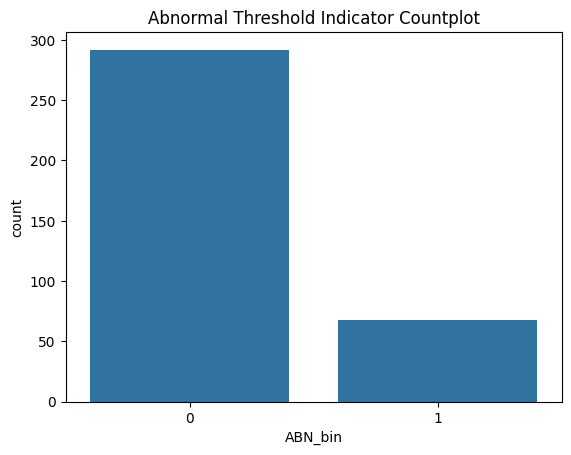

In [86]:
# Checking the label of new data
sns.countplot(df_bin, x='ABN_bin')
plt.title(f"Abnormal Threshold Indicator Countplot")
plt.show()

In [87]:
# Drop NAN
df_bin = df_bin.dropna()

# Columns to drop
columns = ['time_start', 'time_ end', 'DO', 'N', 'ABN', 'ABN%', 'experiment', 'ABN_bin']

# Split to feature and label
X = df_bin.drop(columns=columns)
y = df_bin['ABN_bin']

In [88]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

results = []

# Iterate using from one feature to all feature
for i in range(len(X_train.columns)):
    # Create the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=i+1)),
        ('classifier', LogisticRegression(max_iter=1000))
    ])
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    sel_feat = pipeline.named_steps['feature_selection'].get_feature_names_out(
        input_features=X_train.columns
    )

    # Make predictions
    y_pred = pipeline.predict(X_test)

    result = {
        'data_batch': f"ABN_123",
        'number_feature': i+1,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=True), 
        'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=True),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=True),
    }
    

    # Message
    print(f"\n--- Inspecting Experiment Batch 123 ---")
    print(f"Selected feature: {sel_feat}")
    print(f"--- Results --- \n--- Using {i+1} feature ---")
    print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))
    
    results.append(result)

results = pd.DataFrame(results)


--- Inspecting Experiment Batch 123 ---
Selected feature: ['Fast Swim SUR']
--- Results --- 
--- Using 1 feature ---
              precision    recall  f1-score   support

           0       0.85      0.99      0.92        88
           1       0.83      0.25      0.38        20

    accuracy                           0.85       108
   macro avg       0.84      0.62      0.65       108
weighted avg       0.85      0.85      0.82       108


--- Inspecting Experiment Batch 123 ---
Selected feature: ['Fast Swim SUR' 'SUR']
--- Results --- 
--- Using 2 feature ---
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        88
           1       0.78      0.35      0.48        20

    accuracy                           0.86       108
   macro avg       0.82      0.66      0.70       108
weighted avg       0.85      0.86      0.84       108


--- Inspecting Experiment Batch 123 ---
Selected feature: ['Fast Swim SUR' 'Acc. Ver. SUR' 'SUR']
--- R

In [89]:
print("Based on the results below:")
for idx, scoring in enumerate(['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']):
    num_feature = results.loc[results[scoring].idxmax()]['number_feature']
    print(f"{idx+1}. The best score for {scoring} is {num_feature} features")

Based on the results below:
1. The best score for accuracy is 7 features
2. The best score for precision_weighted is 7 features
3. The best score for recall_weighted is 7 features
4. The best score for f1_weighted is 7 features


In [90]:
# Model selection
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Support Vector Machine': SVC(random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(),
    'Gausian': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE)
}

results = []

# Run average scoring for each model
for name, model in models.items():
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
        ('classifier', model)
    ])

    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=RANDOM_STATE)

    result = {
        'model': name
    }

    for scoring in ['accuracy', 'precision', 'recall', 'f1']:
        scores = cross_val_score(clf, X, y, cv=cv, scoring=scoring)
        result[scoring] = np.mean(scores)

    results.append(result)

results = pd.DataFrame(results)

In [91]:
results.sort_values('f1', ascending=False)

,model,accuracy,precision,recall,f1
5,Gausian,0.857407,0.687007,0.595758,0.633677
4,KNN,0.859259,0.841858,0.441616,0.561431
6,Gradient Boosting,0.840741,0.714590,0.422414,0.516900
2,Random Forest,0.835185,0.686068,0.422081,0.509341
7,AdaBoost,0.833333,0.682906,0.411731,0.496416
0,Logistic Regression,0.846296,0.839048,0.340084,0.468838
3,Support Vector Machine,0.844444,0.862338,0.329271,0.459791
1,Decision Tree,0.805556,0.578846,0.335212,0.417782


In [92]:
clf = models['Gausian']

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
    ('classifier', clf)
])
    
# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Message
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))


              precision    recall  f1-score   support

           0       0.93      0.92      0.93        88
           1       0.67      0.70      0.68        20

    accuracy                           0.88       108
   macro avg       0.80      0.81      0.80       108
weighted avg       0.88      0.88      0.88       108



### Note
Remember that the data is imbalanced, therefore there are several technique that we can use such as Cost Sensitive, Ensemble Method or Data Resampling

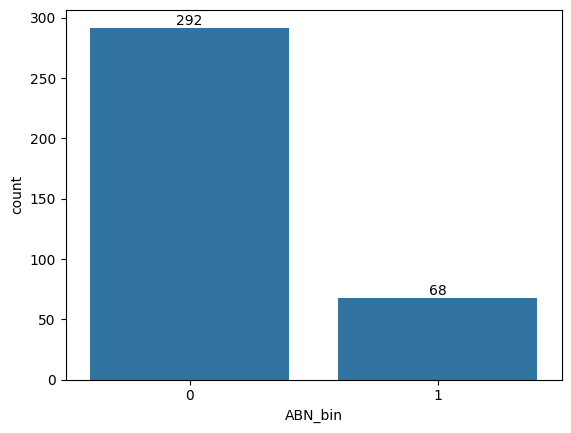

In [93]:
ax = sns.countplot(df_bin, x='ABN_bin')
ax.bar_label(ax.containers[0], fontsize=10)
plt.show()

### Cost Sensitive

In [94]:
results = []
for w in np.arange(0.1, 1.1, 0.1):
    clf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight={0:w})

    # Create the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
        ('classifier', clf)
    ])
        
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Message
    print(f'\n--- Weight 0: {w} ---')
    print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

    result = {
        'weight': w
    }

    for scoring in ['accuracy', 'precision', 'recall', 'f1']:
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)
        result[scoring] = np.mean(scores)

    results.append(result)

results = pd.DataFrame(results)


--- Weight 0: 0.1 ---
              precision    recall  f1-score   support

           0       0.87      0.68      0.76        88
           1       0.28      0.55      0.37        20

    accuracy                           0.66       108
   macro avg       0.58      0.62      0.57       108
weighted avg       0.76      0.66      0.69       108


--- Weight 0: 0.2 ---
              precision    recall  f1-score   support

           0       0.86      0.69      0.77        88
           1       0.27      0.50      0.35        20

    accuracy                           0.66       108
   macro avg       0.56      0.60      0.56       108
weighted avg       0.75      0.66      0.69       108


--- Weight 0: 0.30000000000000004 ---
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        88
           1       0.64      0.45      0.53        20

    accuracy                           0.85       108
   macro avg       0.76      0.70      0.72

In [95]:
results

,weight,accuracy,precision,recall,f1
0,0.1,0.653704,0.319450,0.556150,0.403040
1,0.2,0.785185,0.561338,0.420990,0.456146
2,0.3,0.829630,0.650968,0.408490,0.493470
3,0.4,0.831481,0.656307,0.430081,0.509466
4,0.5,0.835185,0.676068,0.430081,0.515209
5,0.6,0.833333,0.672353,0.417914,0.504784
6,0.7,0.835185,0.678889,0.430414,0.514053
7,0.8,0.833333,0.677296,0.422081,0.506442
8,0.9,0.833333,0.668413,0.429488,0.509333
9,1.0,0.835185,0.686068,0.422081,0.509341


### Ensemble Method

In [96]:
from sklearn.ensemble import StackingClassifier, VotingClassifier

In [97]:
estimators = [
    ('rf', Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
        ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
    ])),
    ('dt', Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
        ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ])),
    ('gnb', Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
        ('classifier', GaussianNB())
    ]))
]

# Choose All
# estimators = []

# for name, model in models.items():
#     estimator = Pipeline([
#         ('scaler', StandardScaler()),
#         ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
#         ('classifier', model)
#     ])

#     estimators.append((name, estimator))

In [98]:
clf = StackingClassifier(estimators=estimators)

# Fit the pipeline
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Message
print(f'\n--- Weight 0: {w} ---')
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

result = {}
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)
    result[scoring] = np.mean(scores)

pd.DataFrame(result, index=[0])


--- Weight 0: 1.0 ---
              precision    recall  f1-score   support

           0       0.89      0.97      0.92        88
           1       0.75      0.45      0.56        20

    accuracy                           0.87       108
   macro avg       0.82      0.71      0.74       108
weighted avg       0.86      0.87      0.86       108



,accuracy,precision,recall,f1
0,0.835185,0.686068,0.422081,0.509341


In [99]:
clf = VotingClassifier(estimators=estimators, voting='soft')

# Fit the pipeline
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Message
print(f'\n--- Weight 0: {w} ---')
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

result = {}
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)
    result[scoring] = np.mean(scores)

pd.DataFrame(result, index=[0])


--- Weight 0: 1.0 ---
              precision    recall  f1-score   support

           0       0.88      0.93      0.91        88
           1       0.60      0.45      0.51        20

    accuracy                           0.84       108
   macro avg       0.74      0.69      0.71       108
weighted avg       0.83      0.84      0.83       108



,accuracy,precision,recall,f1
0,0.835185,0.686068,0.422081,0.509341


### Random Oversampling

Original Data Number: 252
Resample Data Number: 408


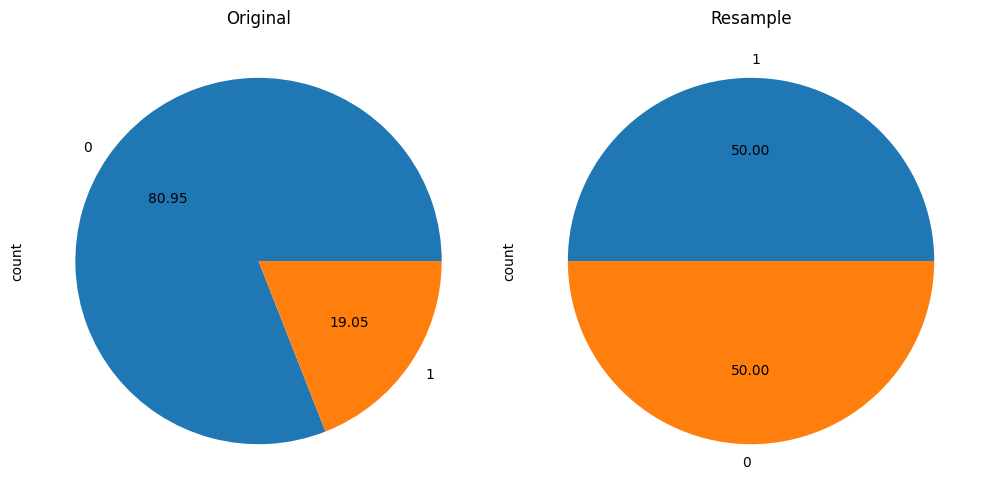

In [100]:
# Random Oversampling
ros = RandomOverSampler(random_state=RANDOM_STATE)

# Resampling data
X_res, y_res = ros.fit_resample(X_train, y_train)

print(f"Original Data Number: {len(X_train)}")
print(f"Resample Data Number: {len(X_res)}")
original_resample(y_train, y_res)

In [101]:
clf = models['Gausian']

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
    ('classifier', clf)
])

# Fit the pipeline
pipeline.fit(X_res, y_res)

# Make predictions
y_pred = pipeline.predict(X_test)

# Message
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        88
           1       0.64      0.70      0.67        20

    accuracy                           0.87       108
   macro avg       0.78      0.80      0.79       108
weighted avg       0.88      0.87      0.87       108



In [102]:
# Take recall average
steps = [
    ('ros_auto', RandomOverSampler(random_state=RANDOM_STATE)),
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
    ('model', clf)
]

pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    print(f"The average scoring of {scoring}: {np.mean(scores)}")

The average scoring of accuracy: 0.8592592592592592
The average scoring of precision: 0.6330351130351132
The average scoring of recall: 0.6674603174603175
The average scoring of f1: 0.6389824826589533


### Random Undersampling

Original Data Number: 252
Resample Data Number: 96


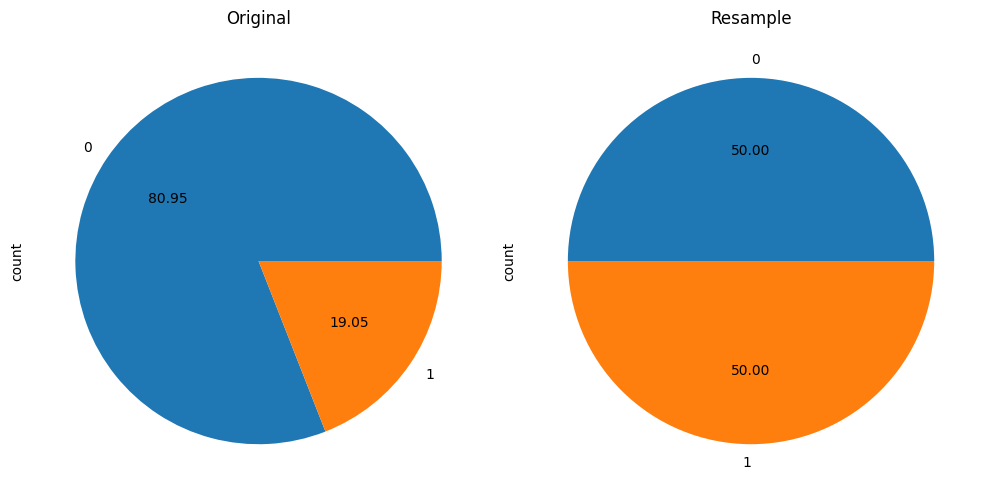

In [103]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)

# Resampling data
X_res, y_res = rus.fit_resample(X_train, y_train)

print(f"Original Data Number: {len(X_train)}")
print(f"Resample Data Number: {len(X_res)}")
original_resample(y_train, y_res)

In [104]:
clf = models['Gausian']

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
    ('classifier', clf)
])

# Fit the pipeline
pipeline.fit(X_res, y_res)

# Make predictions
y_pred = pipeline.predict(X_test)

# Message
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88        88
           1       0.50      0.75      0.60        20

    accuracy                           0.81       108
   macro avg       0.72      0.79      0.74       108
weighted avg       0.86      0.81      0.83       108



In [105]:
# Take recall average
steps = [
    ('rus_auto', RandomUnderSampler(random_state=RANDOM_STATE)),
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
    ('model', clf)
]

pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    print(f"The average scoring of {scoring}: {np.mean(scores)}")

The average scoring of accuracy: 0.8175925925925926
The average scoring of precision: 0.5533658362334833
The average scoring of recall: 0.719047619047619
The average scoring of f1: 0.6055813147731307


### Custom Oversampling

Original Data Number: 252
Resample Data Number: 220


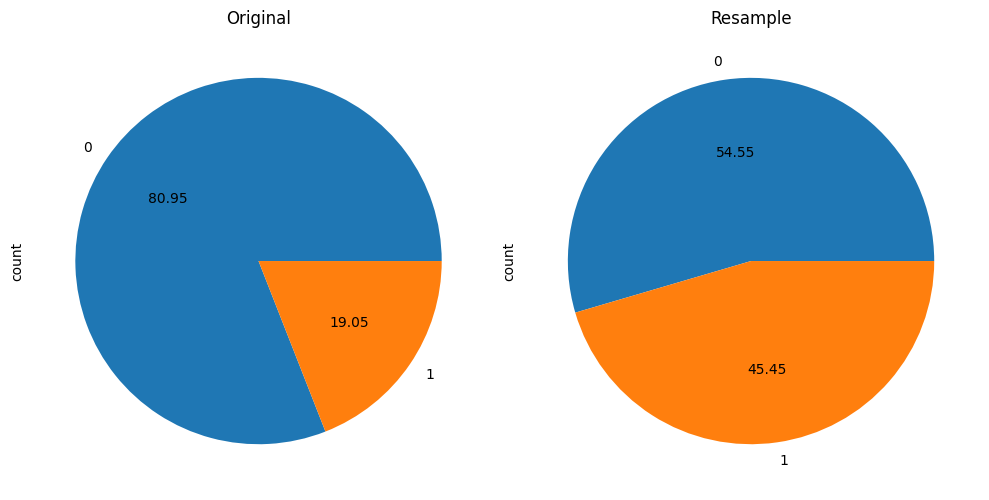

In [106]:
N_RESAMPLE = 20

df_res = df_bin.iloc[X_train.index, :].groupby('ABN').apply(
    lambda x: x.sample(N_RESAMPLE, replace=True, random_state=RANDOM_STATE)
).reset_index(drop=True)

# Split to feature and label
X_res = df_res.drop(columns=columns)
y_res = df_res['ABN_bin']

print(f"Original Data Number: {len(X_train)}")
print(f"Resample Data Number: {len(X_res)}")
original_resample(y_train, y_res)

In [107]:
clf = models['Gausian']

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
    ('classifier', clf)
])

# Fit the pipeline
pipeline.fit(X_res, y_res)

# Make predictions
y_pred = pipeline.predict(X_test)

# Message
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

              precision    recall  f1-score   support

           0       0.95      0.65      0.77        88
           1       0.35      0.85      0.50        20

    accuracy                           0.69       108
   macro avg       0.65      0.75      0.64       108
weighted avg       0.84      0.69      0.72       108



In [108]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    print(f"The average scoring of {scoring}: {np.mean(scores)}")

The average scoring of accuracy: 0.8611111111111109
The average scoring of precision: 0.6465933140933142
The average scoring of recall: 0.6420634920634922
The average scoring of f1: 0.6315309472662415


### Feature Engineering

In [109]:
fe_col = X.columns

def log_transform(df, columns):
    for col in columns:
        new_col = f"{col}_log10"
        df[new_col] = np.log1p(df[col])

    return df[columns]

def square_transform(df, columns):
    for col in columns:
        new_col = f"{col}_square"
        df[new_col] = np.square(df[col])

    return df[columns]

In [110]:
df_fe = df_bin.copy()
df_log = log_transform(df_fe, conti)
df_square = square_transform(df_fe, conti)

df_fe = pd.concat([df_fe, df_log, df_square], axis=1).dropna()

# Split to feature and label
X = df_fe.drop(columns=columns)
y = df_fe['ABN_bin']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [111]:
results = []

# Run average scoring for each model
for name, model in models.items():

    for i in range(len(X_train.columns)//2):
        clf = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(score_func=f_classif, k=i+1)),
            ('classifier', model)
        ])

        # Fit model
        clf.fit(X_train, y_train)

        # Selected feature
        sel_feat = clf.named_steps['feature_selection'].get_feature_names_out(
            input_features=X_train.columns
        )

        # Model prediction
        y_pred = clf.predict(X_test)

        # Store results
        result = {
            'data_batch': f"ABN_123",
            'model': name,
            'number_feature': i+1,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=True), 
            'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=True),
            'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=True)
        }

        print(f"\n--- Inspecting Experiment Batch 123 ---")
        print(f"Selected feature: {sel_feat}")
        print(f"--- Results --- \n--- Using {i+1} feature with {name}---")
        print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

        results.append(result)

results = pd.DataFrame(results)


--- Inspecting Experiment Batch 123 ---
Selected feature: ['Fast Swim SUR_log10']
--- Results --- 
--- Using 1 feature with Logistic Regression---
              precision    recall  f1-score   support

           0       0.86      0.98      0.92        58
           1       0.83      0.36      0.50        14

    accuracy                           0.86        72
   macro avg       0.85      0.67      0.71        72
weighted avg       0.86      0.86      0.84        72


--- Inspecting Experiment Batch 123 ---
Selected feature: ['Fast Swim SUR_log10' 'Fast Swim SUR']
--- Results --- 
--- Using 2 feature with Logistic Regression---
              precision    recall  f1-score   support

           0       0.86      0.98      0.92        58
           1       0.83      0.36      0.50        14

    accuracy                           0.86        72
   macro avg       0.85      0.67      0.71        72
weighted avg       0.86      0.86      0.84        72


--- Inspecting Experiment Batch 1

In [112]:
print('Based on the results')
for idx, scoring in enumerate(['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']):
    num_feature = results.loc[results[scoring].idxmax()]['number_feature']
    model_name = results.loc[results[scoring].idxmax()]['model']

    score = results.loc[results[scoring].idxmax()][scoring]
    print(f"{idx+1}. The best score for {scoring} ({score:.2f}) is {num_feature} features using {model_name}")

Based on the results
1. The best score for accuracy (0.90) is 31 features using Support Vector Machine
2. The best score for precision_macro (0.90) is 31 features using Support Vector Machine
3. The best score for recall_macro (0.82) is 30 features using Gausian
4. The best score for f1_macro (0.83) is 32 features using Support Vector Machine


In [113]:
# SVM Model
results[(
    (results['accuracy'] > 0.9)
    & (results['model'] == 'Support Vector Machine')
)]

,data_batch,model,number_feature,accuracy,precision_macro,recall_macro,f1_macro
150,ABN_123,Support Vector Machine,31,0.902778,0.896825,0.777094,0.818900
151,ABN_123,Support Vector Machine,32,0.902778,0.868107,0.804187,0.830588
152,ABN_123,Support Vector Machine,33,0.902778,0.868107,0.804187,0.830588


In [114]:
# SVM Model
results[(
    (results['recall_macro'] > 0.7)
)]

,data_batch,model,number_feature,accuracy,precision_macro,recall_macro,f1_macro
4,ABN_123,Logistic Regression,5,0.875,0.867033,0.705665,0.749129
5,ABN_123,Logistic Regression,6,0.875,0.867033,0.705665,0.749129
6,ABN_123,Logistic Regression,7,0.875,0.867033,0.705665,0.749129
7,ABN_123,Logistic Regression,8,0.875,0.867033,0.705665,0.749129
8,ABN_123,Logistic Regression,9,0.875,0.867033,0.705665,0.749129
...,...,...,...,...,...,...,...
315,ABN_123,AdaBoost,36,0.875,0.833333,0.732759,0.767158
316,ABN_123,AdaBoost,37,0.875,0.833333,0.732759,0.767158
317,ABN_123,AdaBoost,38,0.875,0.833333,0.732759,0.767158
318,ABN_123,AdaBoost,39,0.875,0.833333,0.732759,0.767158


### Feature Engineering with Custom Oversampling

Original Data Number: 288
Resample Data Number: 220


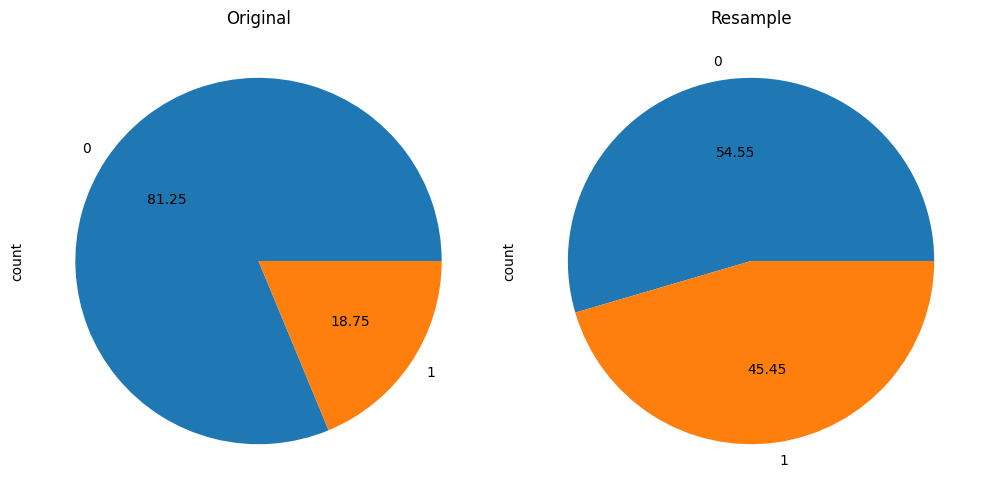

In [115]:
N_RESAMPLE = 20

df_res = df_fe.iloc[X_train.index, :].groupby('ABN').apply(
    lambda x: x.sample(N_RESAMPLE, replace=True, random_state=RANDOM_STATE)
).reset_index(drop=True)

# Split to feature and label
X_res = df_res.drop(columns=columns)
y_res = df_res['ABN_bin']

print(f"Original Data Number: {len(X_train)}")
print(f"Resample Data Number: {len(X_res)}")
original_resample(y_train, y_res)

              precision    recall  f1-score   support

           0       0.97      0.57      0.72        58
           1       0.34      0.93      0.50        14

    accuracy                           0.64        72
   macro avg       0.66      0.75      0.61        72
weighted avg       0.85      0.64      0.68        72



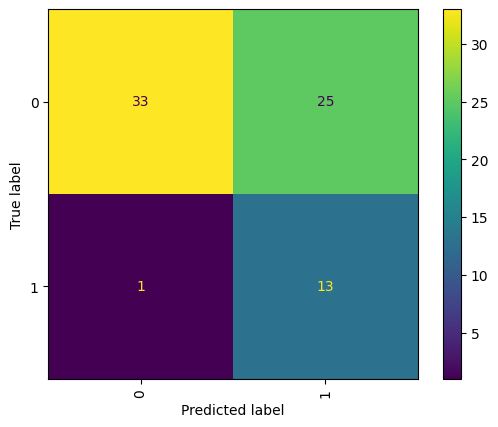

In [116]:
clf = models['Gausian']

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=30)),
    ('classifier', clf)
])

# Fit the pipeline
pipeline.fit(X_res, y_res)

# Make predictions
y_pred = pipeline.predict(X_test)

# Message
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')
plt.show()

In [117]:
# evaluate pipeline
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    print(f"The average scoring of {scoring}: {np.mean(scores)}")

The average scoring of accuracy: 0.8685185185185185
The average scoring of precision: 0.6737169312169313
The average scoring of recall: 0.6190476190476191
The average scoring of f1: 0.6352236652236651


### Gausian Hyperparameter Tuning

In [118]:
TUNING_SCORING = 'accuracy'

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best Parameters: {'model__var_smoothing': 0.12563166024741204}
Best Cross-Validation Score: 0.8161290322580645

--- Results Hyperparameter Tuning Gaussian Naive Bayes (GaussianNB) ---
The average scoring of accuracy: 0.8564814814814816
The average scoring of precision: 0.6701719576719577
The average scoring of recall: 0.5150793650793651
The average scoring of f1: 0.5661734561734562

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.90      0.91        58
           1       0.62      0.71      0.67        14

    accuracy                           0.86        72
   macro avg       0.78      0.81      0.79        72
weighted avg       0.87      0.86      0.86        72



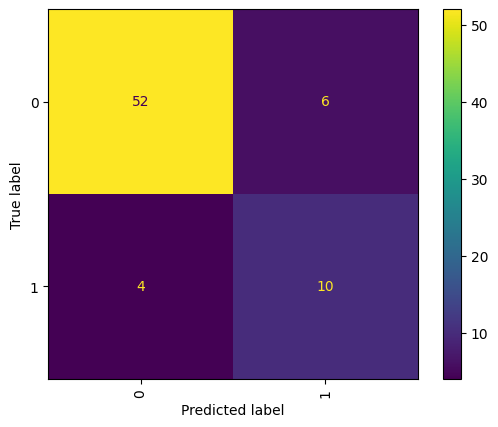

In [120]:
# Resampling data
X_res, y_res = ros.fit_resample(X_train, y_train)

# Define pipeline steps
steps = [
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=30)),
    ('model', models['Gausian'])
]

clf = Pipeline(steps=steps)

# Set up the parameter grid
param_grid = {
    'model__var_smoothing': np.logspace(0, -9, num=1000)  # A range of values for var_smoothing
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid, 
                           scoring=TUNING_SCORING, 
                           cv=5,  # Number of cross-validation folds
                           verbose=1)

# Fit the model
grid_search.fit(X_res, y_res)

# Retrieve the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Hyperparameter
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

print('\n--- Results Hyperparameter Tuning Gaussian Naive Bayes (GaussianNB) ---')
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(grid_search.best_estimator_, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    print(f"The average scoring of {scoring}: {np.mean(scores)}")

# Make predictions
y_pred = grid_search.best_estimator_.predict(X_test)

# Message
print('\n--- Classification Report ---')
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')
plt.show()

In [121]:
df_all

,time_start,time_ end,DO,Hovering BTM,Hovering MID,Hovering SUR,Fast Swim Btm,Fast Swim Mid,Fast Swim SUR,Acc. Ver. MID,...,Burst Swimming,Resting,Active,BTM,MID,SUR,N,ABN,ABN%,experiment
0,00:00:00,00:01:00,6.16,3.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,7.0,3.0,10.0,0.0,0.0,10.0,0.0,0.0,ABN_B1
1,00:01:00,00:02:00,6.10,2.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,7.0,3.0,10.0,0.0,0.0,10.0,0.0,0.0,ABN_B1
2,00:02:00,00:03:00,6.08,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,8.0,2.0,10.0,0.0,0.0,10.0,0.0,0.0,ABN_B1
3,00:03:00,00:04:00,6.08,5.0,0.0,0.0,4.0,0.0,0.0,2.0,...,0.0,6.0,4.0,9.0,1.0,0.0,10.0,0.0,0.0,ABN_B1
4,00:04:00,00:05:00,5.96,6.0,0.0,0.0,4.0,0.0,0.0,1.0,...,0.0,6.0,4.0,9.0,1.0,0.0,10.0,0.0,0.0,ABN_B1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,02:02:00,02:03:00,3.39,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,9.0,1.0,9.0,0.0,1.0,0.0,10.0,100.0,ABN_B3
356,02:03:00,02:04:00,3.38,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,2.0,7.0,3.0,7.0,0.0,3.0,0.0,10.0,100.0,ABN_B3
357,02:04:00,02:05:00,3.37,1.0,0.0,0.0,0.0,0.0,4.0,0.0,...,1.0,8.0,2.0,8.0,2.0,0.0,0.0,10.0,100.0,ABN_B3
358,02:05:00,02:06:00,3.36,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,1.0,9.0,1.0,9.0,1.0,0.0,0.0,10.0,100.0,ABN_B3


### Feature Selection On All Batch

In [ ]:
conti = [
    'Hovering BTM', 
    'Hovering MID',
    'Hovering SUR', 
    'Fast Swim Btm', 
    'Fast Swim Mid', 
    'Fast Swim SUR',
    'Acc. Ver. MID', 
    'Acc. Ver. SUR', 
    'Turning', 
    'Agg. Behaviour',
    'Burst Swimming', 
    'Resting', 
    'Active', 
    'BTM', 
    'MID', 
    'SUR']

def log_transform(df, columns):
    for col in columns:
        new_col = f"{col}_log10"
        df[new_col] = np.log1p(df[col])

    return df[columns]

def square_transform(df, columns):
    for col in columns:
        new_col = f"{col}_square"
        df[new_col] = np.square(df[col])

    return df[columns]

In [ ]:
df = df_all.copy()
df_log = log_transform(df, conti)
df_square = square_transform(df, conti)

df = pd.concat([df, df_log, df_square], axis=1).dropna()

# Split to feature and label
X = df.drop(columns=['time_start', 'time_ end', 'DO', 'N', 'ABN', 'ABN%'])
y = df['ABN']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

result = feature_selector(X_train, y_train, X_test, y_test, experiment_batch=123, verbose=1)

In [ ]:
models = [
    LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    RandomForestClassifier(random_state=RANDOM_STATE),
    SVC(random_state=RANDOM_STATE),
    KNeighborsClassifier(),
    GaussianNB(),
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    AdaBoostClassifier(random_state=RANDOM_STATE),
    QuadraticDiscriminantAnalysis(),
    LinearDiscriminantAnalysis()
]

for model in models:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=51)),
        ('classifier', model)
    ])

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    print(f"\n--- Results {model} ---")
    print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

### Feature Selection On Specific Batch

In [ ]:
results = pd.DataFrame()
for i in range(3):
    # Experiment batch
    experiment = f"ABN_B{i+1}"
    # Load csv data
    df = pd.read_csv(eval(experiment))

    # Feature and label
    df = df.iloc[:, 3:].dropna()

    # Resample as some level only has 1
    df = df.groupby('ABN').apply(
        lambda x: x.sample(50, replace=True, random_state=RANDOM_STATE)
    ).reset_index(drop=True)

    # Split to feature and label
    X = df.drop(columns=['N', 'ABN', 'ABN%'])
    y = df['ABN']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

    result = feature_selector(X_train, y_train, X_test, y_test, experiment_batch=i+1, verbose=1)
    results = pd.concat([results, result])

In [ ]:
results.sort_values('accuracy', ascending=False)

In [ ]:
results = []

for i in range(3):
    # Experiment batch
    experiment = f"ABN_B{i+1}"
    # Load csv data
    df = pd.read_csv(eval(experiment))

    # Feature and label
    df = df.iloc[:, 3:].dropna()

    # Resample as some level only has 1
    df = df.groupby('ABN').apply(
        lambda x: x.sample(50, replace=True, random_state=RANDOM_STATE)
    ).reset_index(drop=True)

    # Split to feature and label
    X = df.drop(columns=['N', 'ABN', 'ABN%'])
    y = df['ABN']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

    # Iterate using from one feature to all feature
    for i in range(len(X.columns)):
        # Create the pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(score_func=f_classif, k=i+1)),
            ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
        ])
        
        # Fit the pipeline
        pipeline.fit(X_train, y_train)

        sel_feat = pipeline.named_steps['feature_selection'].get_feature_names_out(
            input_features=X.columns
        )

        # Make predictions
        y_pred = pipeline.predict(X_test)

        result = {
            'data_batch': experiment,
            'number_feature': i+1,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=True), 
            'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=True),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=True)
        }
        
        results.append(result)
        
        # Message
        print(f"\n--- Inspecting Experiment Batch {experiment}1 ---")
        print(f"Selected feature: {sel_feat}")
        print(f"--- Results --- \n--- Using {i+1} feature ---")
        print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

results = pd.DataFrame(results)

In [ ]:
results.sort_values('accuracy', ascending=False)

In [ ]:
for i in range(3):
    # Experiment batch
    experiment = f"ABN_B{i+1}"
    # Load csv data
    df = pd.read_csv(eval(experiment))

    # Feature and label
    df = df.iloc[:, 3:].dropna()

    # Resample as some level only has 1
    df = df.groupby('ABN').apply(
        lambda x: x.sample(50, replace=True, random_state=RANDOM_STATE)
    ).reset_index(drop=True)

    # Split to feature and label
    X = df.drop(columns=['N', 'ABN', 'ABN%'])
    y = df['ABN']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

    # Initializing and training the Random Forest Classifier
    model = RandomForestClassifier(random_state=RANDOM_STATE)
    model.fit(X_train, y_train)

    # Getting feature importance
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plotting the feature importances
    plt.figure(figsize=(12, 6))
    sns.barplot(x=importances[indices], y=np.array(X.columns)[indices], hue=np.array(X.columns)[indices], palette='viridis')
    plt.title(f'Feature Importance {experiment}')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

In [ ]:
# Experiment batch
experiment = results.loc[results['accuracy'].idxmax()]['data_batch']

# Number feature
n_feature = results.sort_values('accuracy', ascending=False)['number_feature'][0]

# Load csv data
df = pd.read_csv(eval(experiment))

# Message
print(f"\n--- Inspecting Experiment Batch {experiment} ---")

# Feature and label
df = df.iloc[:, 3:].dropna()

# Resample as some level only has 1 value
df = df.groupby('ABN').apply(
    lambda x: x.sample(50, replace=True, random_state=RANDOM_STATE)
).reset_index(drop=True)

# Split to feature and label
X = df.drop(columns=['N', 'ABN', 'ABN%'])
y = df['ABN']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=n_feature)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

print(f"--- Results ---")
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

In [ ]:
# Since we are training with B3, lets test with B1 and B2

# Load B1 and B2 csv data
df12 = pd.concat([
    pd.read_csv(ABN_B1),
    pd.read_csv(ABN_B2)
])

# Split to feature and label
X = df.drop(columns=['N', 'ABN', 'ABN%'])
y = df['ABN']

# Make predictions
y_pred = pipeline.predict(X)

print(f"--- Results ---")
print(classification_report(y, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

In [ ]:
# As B1 has lack data for the abnormal level, it is combine with B2 or B3
results = []

for i in [2, 3]:
    # Load batch 1
    df = pd.read_csv(ABN_B1)

    # Experiment batch
    experiment = f"ABN_B{i}"

    # Load csv data
    df = pd.concat([df, pd.read_csv(eval(experiment))], axis=0)

    # Feature and label
    df = df.iloc[:, 3:].dropna()

    # Resample as some level only has 1
    df = df.groupby('ABN').apply(
        lambda x: x.sample(50, replace=True, random_state=RANDOM_STATE)
    ).reset_index(drop=True)

    # Split to feature and label
    X = df.drop(columns=['N', 'ABN', 'ABN%'])
    y = df['ABN']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

    if i == 2:
        df_val = pd.read_csv(ABN_B2).dropna()
    else:
        df_val = pd.read_csv(ABN_B3).dropna()

    X_val = df_val[X.columns]
    y_val = df_val['ABN']

    # Iterate using from one feature to all feature
    for i in range(len(X.columns)):
        # Create the pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(score_func=f_classif, k=i+1)),
            ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
        ])
        
        # Fit the pipeline
        pipeline.fit(X_train, y_train)

        sel_feat = pipeline.named_steps['feature_selection'].get_feature_names_out(
            input_features=X.columns
        )

        # Make predictions
        y_pred = pipeline.predict(X_test)
        y_val_pred = pipeline.predict(X_val)

        result = {
            'data_batch': experiment,
            'number_feature': i+1,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=True), 
            'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=True),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=True)
        }
        
        results.append(result)

        # Message
        print(f"\n--- Inspecting Experiment Batch {experiment}1 ---")
        print(f"Selected feature: {sel_feat}")
        print(f"--- Results --- \n--- Using {i+1} feature ---")
        print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

        print("--- Validation Results ---")
        print(classification_report(y_val, y_val_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

results = pd.DataFrame(results)

In [ ]:
results.sort_values('accuracy', ascending=False)

In [ ]:
df_train = pd.concat([
    pd.read_csv(ABN_B1).dropna(),
    pd.read_csv(ABN_B3).dropna()
]).reset_index(drop=True)

feature_selected = ['Hovering BTM', 'Fast Swim SUR', 'Acc. Ver. SUR', 'Turning', 'Burst Swimming']

X = df_train[feature_selected]
y = df_train['ABN']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

models = [
    LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    RandomForestClassifier(random_state=RANDOM_STATE),
    SVC(random_state=RANDOM_STATE)
]

for model in models:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    print(f"\n--- Results {model} ---")
    print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

In [ ]:
# Custom scoring function to prioritize recall for specific classes
def custom_recall_score(y_true, y_pred):
    recalls = recall_score(y_true, y_pred, average=None)
    # return recall for class 10
    return np.mean(recalls[2])

# Create a custom scorer
custom_scorer = make_scorer(custom_recall_score)

# Define the parameter distribution for random search
param_dist = {
    'n_estimators': np.arange(100, 500, 100),
    'min_samples_split': np.arange(2, 20),
    'min_samples_leaf': np.arange(1, 20),
    'max_features': np.random.uniform(0.1, 0.9, 20),  # Continuous uniform distribution
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}

# Create a random forest classifier
rf = RandomForestClassifier(random_state=RANDOM_STATE)

# Create the random search object
random_search = GridSearchCV(
    estimator=rf,
    param_grid=param_dist,
    cv=2,
    verbose=2,
    n_jobs=-1,
    scoring=custom_scorer
)

# Fit the random search object to the data
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Get the best model
best_rf = random_search.best_estimator_

# Evaluate on the test set
test_score = best_rf.score(X_test, y_test)
print("Test set score:", test_score)

recall_10_score = custom_recall_score(y_test, best_rf.predict(X_test))
print(f"Recall 10 score: {recall_10_score}")

# Feature importance
feature_importance = best_rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

print("\nTop 5 most important features:")
for i in sorted_idx[-5:]:
    print(f"Feature {i}: {feature_importance[i]:.4f}")

# Calculate mean and standard deviation of trees in the forest
n_trees = best_rf.n_estimators
depths = np.zeros(n_trees)

for i, tree in enumerate(best_rf.estimators_):
    depths[i] = tree.tree_.max_depth

print(f"\nMean tree depth: {np.mean(depths):.2f}")
print(f"Standard deviation of tree depths: {np.std(depths):.2f}")

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', best_rf)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

print(f"\n--- Results {model} ---")
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

In [ ]:
# read batch 1
df = pd.read_csv(ABN_B1)

# read combination experiment
experiment = results.sort_values('accuracy', ascending=False)['data_batch'][0]
dfc = pd.read_csv(eval(experiment))

# combine
df = pd.concat([df, dfc])

# Feature and label
df = df.iloc[:, 3:].dropna()

# Resample as some level only has 1
df = df.groupby('ABN').apply(
    lambda x: x.sample(50, replace=True, random_state=RANDOM_STATE)
).reset_index(drop=True)

# Split to feature and label
X = df.drop(columns=['N', 'ABN', 'ABN%'])
y = df['ABN']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=15)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

print(f"--- Results ---")
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

### Feature Selection On All Data

In [ ]:
results = []

# Feature and label
df = df_all.iloc[:, 3:].dropna()

# Split to feature and label
X = df.drop(columns=['N', 'ABN', 'ABN%'])
y = df['ABN']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Iterate using from one feature to all feature
for i in range(len(X.columns)):
    # Create the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=i+1)),
        ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ])
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    result = {
        'data_batch': "ABN_B123",
        'number_feature': i+1,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=True), 
        'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=True),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=True),
        'recall_level_10': recall_level_10(y_test, y_pred)
    }
    
    results.append(result)
    
    # Message
    print(f"\n--- Inspecting Experiment Batch {experiment} ---")
    print(f"--- Results --- \n--- Using {i+1} feature ---")
    print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

results = pd.DataFrame(results)

In [ ]:
results.sort_values('recall_level_10', ascending=False)

In [ ]:
# Split to feature and label
X = df.drop(columns=['N', 'ABN', 'ABN%'])
y = df['ABN']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Initializing and training the Random Forest Classifier
model = RandomForestClassifier(random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Getting feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plotting the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=np.array(X.columns)[indices], hue=np.array(X.columns)[indices], palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [ ]:
results = []

# Feature and label
df = df_all.iloc[:, 3:].dropna()

# Split to feature and label
X = df[['Turning', 'Burst Swimming']]
y = df['ABN']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)


# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Message
print(f"--- Results ---")
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')
disp.figure_.suptitle("Confusion Matrix")
plt.show()

In [ ]:
y_train.value_counts()

In [ ]:
def original_resample(y_train, y_res):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    autopct = "%.2f"
    y_train.value_counts().plot.pie(autopct=autopct, ax=axs[0])
    axs[0].set_title("Original")
    y_res.value_counts().plot.pie(autopct=autopct, ax=axs[1])
    axs[1].set_title("Resample")
    fig.tight_layout()

In [ ]:
N_RESAMPLE = 50
results = []

# Feature and label
df = df_all.iloc[:, 3:].dropna()

# Split to feature and label
X = df.drop(columns=['N', 'ABN', 'ABN%'])
y = df['ABN']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

df_res = df_all.iloc[X_train.index, :].groupby('ABN').apply(
    lambda x: x.sample(N_RESAMPLE, replace=True, random_state=RANDOM_STATE)
).reset_index(drop=True)

df_res = df_res.iloc[:, 3:]

# Split to feature and label
X_res = df_res.drop(columns=['N', 'ABN', 'ABN%'])
y_res = df_res['ABN']


print(f"Original Data Number: {len(X_train)}")
print(f"Resample Data Number: {len(X_res)}")
original_resample(y_train, y_res)

# Iterate using from one feature to all feature
for i in range(len(X.columns)):
    # Create the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=i+1)),
        ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ])
    
    # Fit the pipeline
    pipeline.fit(X_res, y_res)

    sel_feat = pipeline.named_steps['feature_selection'].get_feature_names_out(
        input_features=X.columns
    )

    # Make predictions
    y_pred = pipeline.predict(X_test)

    result = {
        'data_batch': "ABN_B123",
        'number_feature': i+1,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=True), 
        'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=True),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=True)
    }
    
    results.append(result)
    
    # Message
    print(f"\n--- Inspecting Experiment Batch 123 ---")
    print(f"Selected feature: {sel_feat}")
    print(f"--- Results --- \n--- Using {i+1} feature ---")
    print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

results = pd.DataFrame(results)

In [ ]:
results.sort_values('accuracy', ascending=False)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

In [ ]:
# Feature and label
df = df_all.iloc[:, 3:].dropna()

# Split to feature and label
X = df[['Turning', 'Burst Swimming']]
y = df['ABN']

steps = [
    ('rus_auto', RandomUnderSampler(random_state=RANDOM_STATE)),
    ('model', LogisticRegression(random_state=RANDOM_STATE))
]

pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)
scores = cross_val_score(pipeline, X, y, scoring='recall_weighted', cv=cv, n_jobs=-1)
print('Mean recall: %.3f' % np.mean(scores))

In [ ]:
results = []

# Feature and label
df = df_all.iloc[:, 3:].dropna()

# Split to feature and label
X = df.drop(columns=['N', 'ABN', 'ABN%'])
y = df['ABN']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

rus = RandomUnderSampler(random_state=RANDOM_STATE)

X_res, y_res = rus.fit_resample(X_train, y_train)

print(f"Original Data Number: {len(X_train)}")
print(f"Resample Data Number: {len(X_res)}")
original_resample(y_train, y_res)

# Iterate using from one feature to all feature
for i in range(len(X.columns)):
    # Create the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=i+1)),
        ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ])
    
    # Fit the pipeline
    pipeline.fit(X_res, y_res)

    sel_feat = pipeline.named_steps['feature_selection'].get_feature_names_out(
        input_features=X.columns
    )

    # Make predictions
    y_pred = pipeline.predict(X_test)

    result = {
        'data_batch': "ABN_B123",
        'number_feature': i+1,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=True), 
        'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=True),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=True)
    }
    
    results.append(result)
    
    # Message
    print(f"\n--- Inspecting Experiment Batch 123 ---")
    print(f"Selected feature: {sel_feat}")
    print(f"--- Results --- \n--- Using {i+1} feature ---")
    print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

results = pd.DataFrame(results)

In [ ]:
results.sort_values('accuracy', ascending=False)

In [ ]:
results = []

# Feature and label
df = df_all.iloc[:, 3:].dropna()

# Split to feature and label
X = df.drop(columns=['N', 'ABN', 'ABN%'])
y = df['ABN']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

ros = RandomOverSampler(random_state=RANDOM_STATE)

X_res, y_res = ros.fit_resample(X_train, y_train)


print(f"Original Data Number: {len(X_train)}")
print(f"Resample Data Number: {len(X_res)}")
original_resample(y_train, y_res)


# Iterate using from one feature to all feature
for i in range(len(X.columns)):
    # Create the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=i+1)),
        ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ])
    
    # Fit the pipeline
    pipeline.fit(X_res, y_res)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    sel_feat = pipeline.named_steps['feature_selection'].get_feature_names_out(
        input_features=X.columns
    )

    result = {
        'data_batch': "ABN_B123",
        'number_feature': i+1,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=True), 
        'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=True),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=True)
    }
    
    results.append(result)
    
    # Message
    print(f"\n--- Inspecting Experiment Batch 123 ---")
    print(f"Selected feature: {sel_feat}")
    print(f"--- Results --- \n--- Using {i+1} feature ---")
    print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

results = pd.DataFrame(results)

In [ ]:
results.sort_values('accuracy', ascending=False)

In [ ]:
df.columns